# Introduction 👋🏼
__The Goal__ - Develop an unsupervised learning approach to group patent claims into distinct topics.</br>
In this notebook I will show various approaches for the goal:</br>

## Clustering Algorithms:

1. **K-Means**: K-means is a simple technique for grouping data. It forms clusters of data points that are alike, making sure each group's center (centroid) is positioned to keep the group as tight as possible.

2. **Hierarchical Clustering**: This method sorts data into a tree-like structure of clusters. It starts by treating each data point as its own cluster and then gradually merges them into larger and larger clusters based on how close they are to each other.

## Embeddings:

1. **TF-IDF Vectorization**: This technique quantifies the importance of a word in a document relative to a collection of documents, highlighting words that are frequent in a specific document but not commonly used across other documents.

2. **Sentence Transformer**: Sentence Transformers are models that process text to generate embeddings that can effectively represent the semantic similarity between sentences.

3. **GloVe (Global Vectors for Word Representation)**: is an unsupervised learning model for generating word embeddings by aggregating global word-word co-occurrence statistics from a corpus.

4. **BERT**: In BERT models, the [CLS] token is used at the beginning of each input sequence; its corresponding output embedding serves as the aggregate representation for classification tasks.

5. **GPT2**: Each token's embedding is designed to capture not just the word itself, but also its context within the sentence, facilitating better understanding and generation of coherent text.


Websites:
1. https://www.displayr.com/understanding-cluster-analysis-a-comprehensive-guide/
2. https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
3. https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93
4. https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
5. https://vitalflux.com/find-topics-of-text-clustering-python-examples/

# Data Exploring and Clustering

## 1. Data fetching and preprocessing

In [70]:
import pandas as pd

# Load data
csv_data_path = './data_files/normalized_patent_claims.csv'
df = pd.read_csv(csv_data_path)

In [71]:
# Display first 5 rows and shape
print(f"Shape of dataframe: {df.shape}")
df.head()

Shape of dataframe: (61, 2)


,Patent URL,Normalized Claim
0,https://patents.google.com/patent/GB2478972A/e...,claim wireless telephone comprising handset on...
1,https://patents.google.com/patent/GB2478972A/e...,ftirther comprising body cradle handset onloff...
2,https://patents.google.com/patent/GB2478972A/e...,ftirther comprising call receiving mean receiv...
3,https://patents.google.com/patent/GB2478972A/e...,first predetermined button redial button
4,https://patents.google.com/patent/GB2478972A/e...,transfer mean toggle first call putting either...


In [72]:
# Check for missing values
missing_data = df['Normalized Claim'].isnull().sum()
print(f"Number of missing values in 'normalized_claims': {missing_data}")

Number of missing values in 'normalized_claims': 0


In [73]:
# Function to count unique words
def count_unique_words(df: pd.DataFrame):
    
    # Initialize an empty set to store unique words
    unique_words = set()

    # Iterate over each normalized claim in the DataFrame
    for claim in df['Normalized Claim']:
        
        # Split the claim into words and update the set
        words = claim.split()
        unique_words.update(words)
    
    return unique_words

print(f"There are {len(count_unique_words(df))} unique words.")

There are 243 unique words.


## 2. Embeddings

### 2.1 TF-IDF Vectorrization:

In [74]:
from scipy import sparse

# Load the TF-IDF matrix
matrix_path = './data_files/tfidf_matrix.npz'
tfidf_matrix = sparse.load_npz(matrix_path)

# Show the shape of the matrix
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")

Shape of TF-IDF matrix: (61, 243)


Note: For the above, I wanted to check if the dimensions of the matrix and the unique words from the DataFrame are equal.

### 2.2 Sentence Transformer

In [75]:
import pandas as pd

# Create a new DataFrame
df_embeddings = pd.DataFrame()
df_embeddings['Normalized Claim'] = df['Normalized Claim']

In [76]:
from sentence_transformers import SentenceTransformer

# Load Sentence Transformer Model
model_st = SentenceTransformer('all-MiniLM-L6-v2')

# Apply Sentence Transformer embeddings
df_embeddings['Sentence Transformer Embedding'] = df_embeddings['Normalized Claim'].apply(lambda x: model_st.encode(x))


/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 2.3 GloVe

In [77]:
import numpy as np

# Load GloVe model
def load_glove_embeddings(path):
    with open(path, 'r', encoding='utf-8') as f:
        glove_embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings('glove.6B.50d.txt')

# Define function to get mean vector for GloVe
def get_mean_vector(glove_embeddings, words):
    
    # Filter words that are in the GloVe dictionary
    vectors = [glove_embeddings[word] for word in words if word in glove_embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(50)

# Apply GloVe embeddings
df_embeddings['GloVe Embedding'] = df_embeddings['Normalized Claim'].apply(lambda x: get_mean_vector(glove_embeddings, x.split()))

Note: I tried to download the GloVe model from the web using</br>
`import gensim.downloader as api`</br>
`glove_model = api.load("glove-wiki-gigaword-50")`</br>
But I got an import error.. so I downloaded the model to my machine `glove.6B.txt` and use it for the analysis.</br>
It can be downloaded at `https://nlp.stanford.edu/projects/glove/`

### 2.4 BERT

In [78]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Function to encode text into BERT embeddings
def bert_encode(text):
    
    # Tokenize and encode the input text
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model_bert(**encoded_input)
    
    return output.last_hidden_state[:, 0, :].squeeze().numpy()  # Flatten the [CLS] token's embedding


# Apply BERT embeddings
df_embeddings['BERT Embedding'] = df_embeddings['Normalized Claim'].apply(lambda x: bert_encode(x))


/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 2.5 GPT2

In [79]:
# Import necessary libraries
from transformers import GPT2Model, GPT2Tokenizer
import torch

# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Function to encode text into GPT-2 embeddings
def gpt2_encode(text):
    
    # Tokenize and encode the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply GPT-2 embeddings
df_embeddings['GPT-2 Embedding'] = df_embeddings['Normalized Claim'].apply(lambda x: gpt2_encode(x))

/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [80]:
# Show DataFrame
print(df_embeddings.head())

                                    Normalized Claim  \
0  claim wireless telephone comprising handset on...   
1  ftirther comprising body cradle handset onloff...   
2  ftirther comprising call receiving mean receiv...   
3           first predetermined button redial button   
4  transfer mean toggle first call putting either...   

                      Sentence Transformer Embedding  \
0  [-0.22563359, 0.107961364, -0.0037948426, -0.0...   
1  [-0.0523652, -0.0029035953, -0.060308173, 0.03...   
2  [-0.06748142, -0.07710497, -0.08051407, 0.0463...   
3  [-0.03419592, -0.08175099, -0.014544827, 0.048...   
4  [-0.08252928, -0.040655434, 0.0034108865, -0.0...   

                                     GloVe Embedding  \
0  [0.44159374, 0.08193258, 0.5986013, 0.41752195...   
1  [0.18932654, -0.23008753, 0.33775547, 0.121152...   
2  [0.18735641, 0.10589609, 0.022934198, -0.08592...   
3  [-0.653892, -0.15915959, 0.3457512, 0.54091895...   
4  [0.075757496, 0.14736699, 0.15391098, -0.11

## 3. Experiment Experiment Experiment

### Elbow Method 🦾
Used to determine the optimal number of clusters by looking for the 'elbow point'.

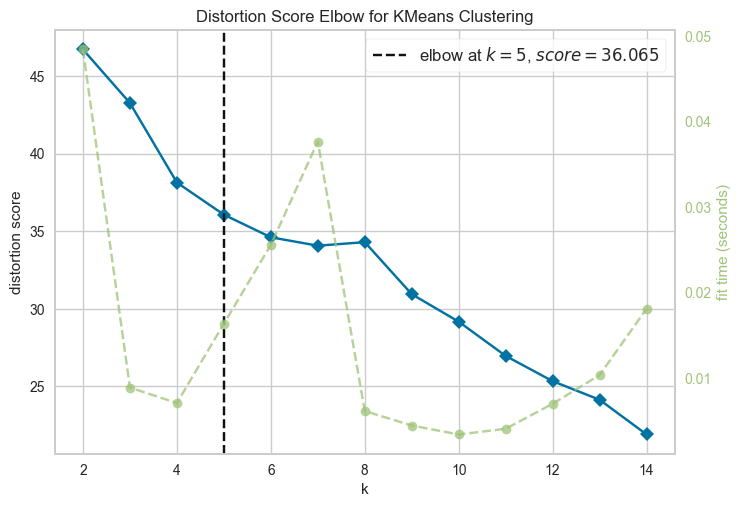

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
# Import necessary libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Initialize the KMeans model
model = KMeans(random_state=42)

# Initialize the KElbowVisualizer with the KMeans model
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,15), timings=True)

# Fit the data to the visualizer
visualizer.fit(tfidf_matrix.toarray())

# Render the plot
visualizer.show()

### 3.1 K-Means using TF-IDF

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Principal Component Analysis for dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Silhouette Score - measure of how well each data point fits into its cluster
from scipy.sparse import csr_matrix # Compressed Sparse Row - used for sparse matrices

def cluster_and_visualize(tfidf_matrix: csr_matrix, k: int):
    """
    Cluster the given TF-IDF matrix using K-Means and visualize the clusters.
    
    Parameters:
    tfidf_matrix (csr_matrix): The TF-IDF matrix to be clustered in csr format.
    k (int): The number of clusters to create.
    
    Returns:
    None. The function only prints the average silhouette score for each cluster and visualizes the clusters in a 2D plot.
    """
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"For {k} clusters, the average silhouette score is: {100*silhouette_avg:.2f}%")
    
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2) # Set PCA to 2D
    reduced_features = pca.fit_transform(tfidf_matrix.toarray()) # Transform the TF-IDF matrix to 2D
    centroids = kmeans.cluster_centers_
    reduced_centroids = pca.transform(centroids) # Transform the centroids to 2D
    
    # Create a color map
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], 
                    color=color, label=f'Cluster {i}', alpha=1)

    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=150, c='black', label='Centroids')
    plt.title(f'2D PCA of {k} Clusters with Centroids')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best')
    plt.show()

For 2 clusters, the average silhouette score is: 12.71%


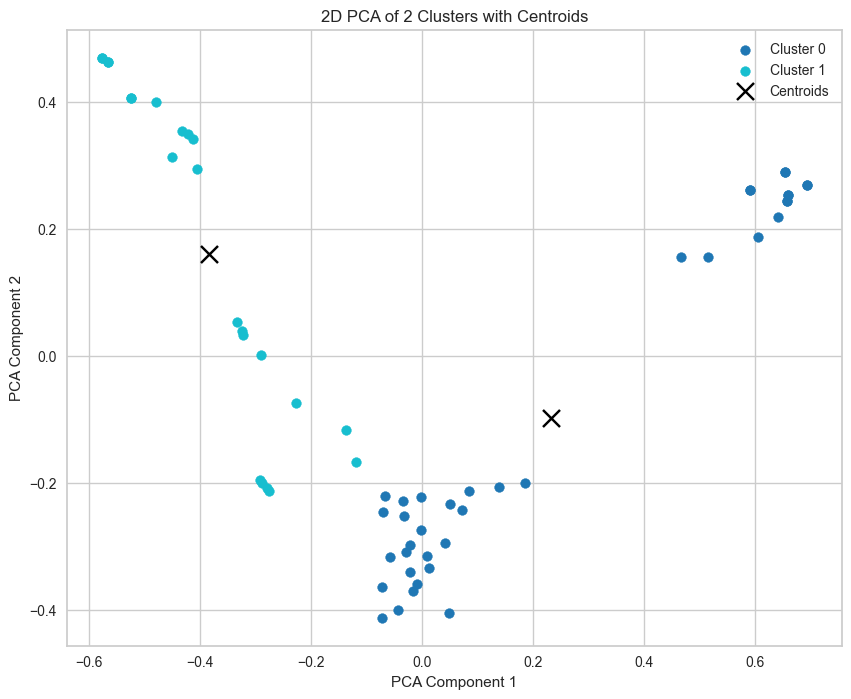

For 3 clusters, the average silhouette score is: 15.41%


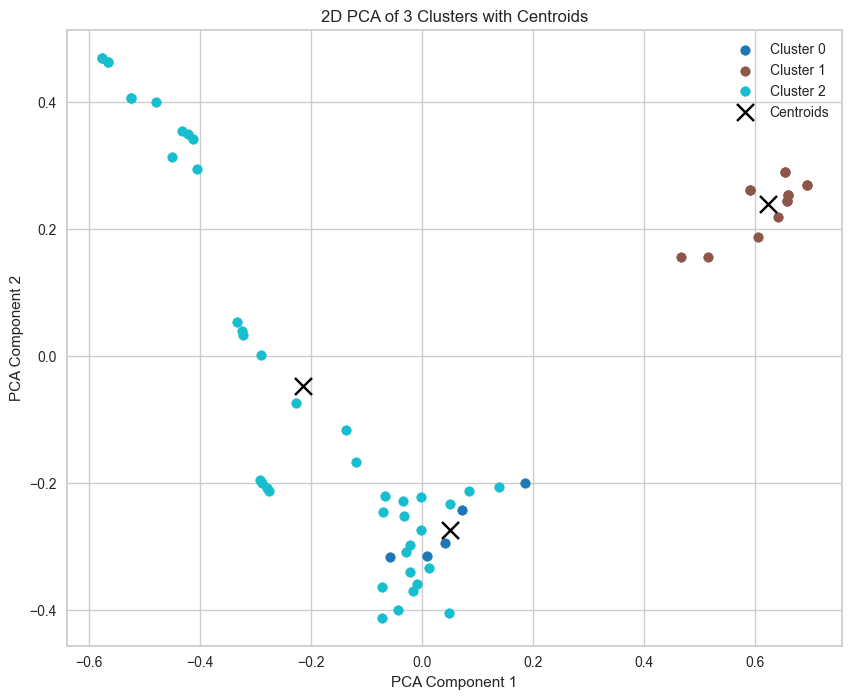

For 4 clusters, the average silhouette score is: 19.45%


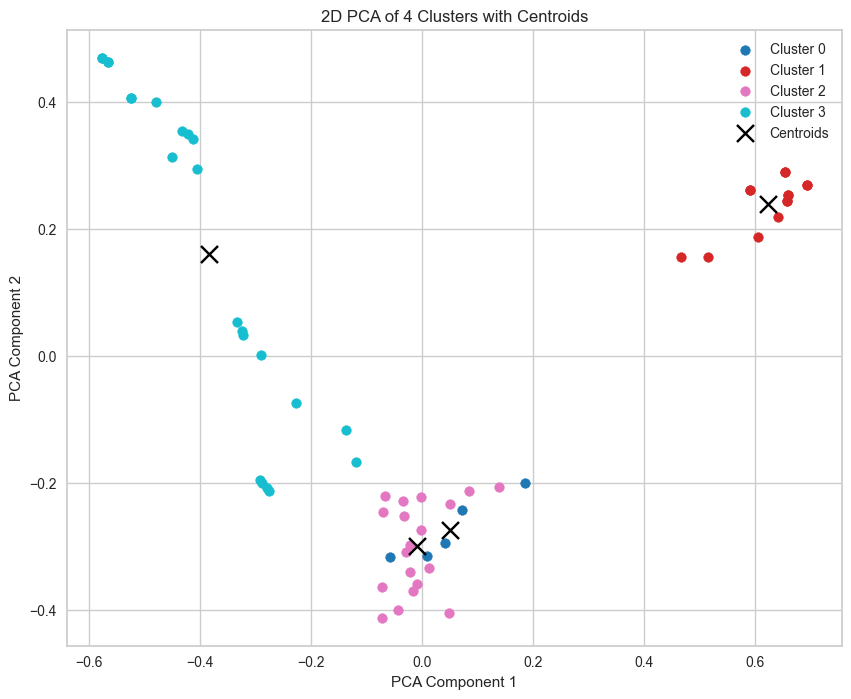

For 5 clusters, the average silhouette score is: 18.24%


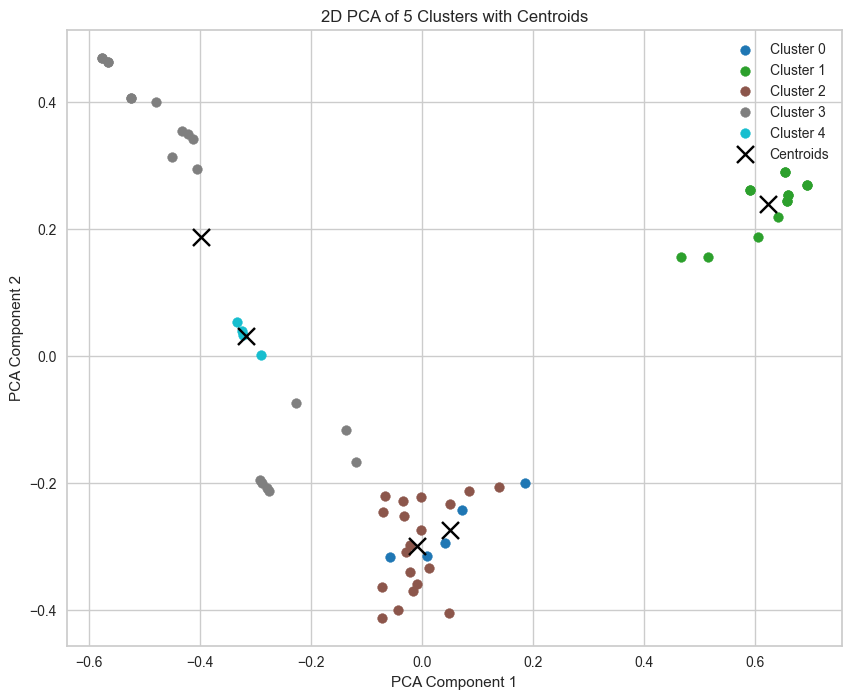

For 6 clusters, the average silhouette score is: 18.94%


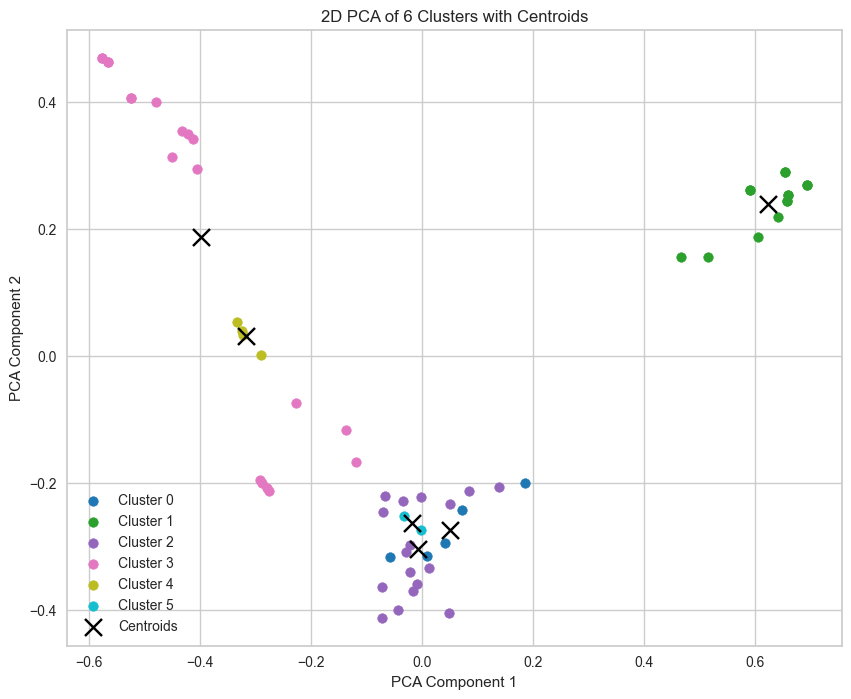

For 7 clusters, the average silhouette score is: 14.20%


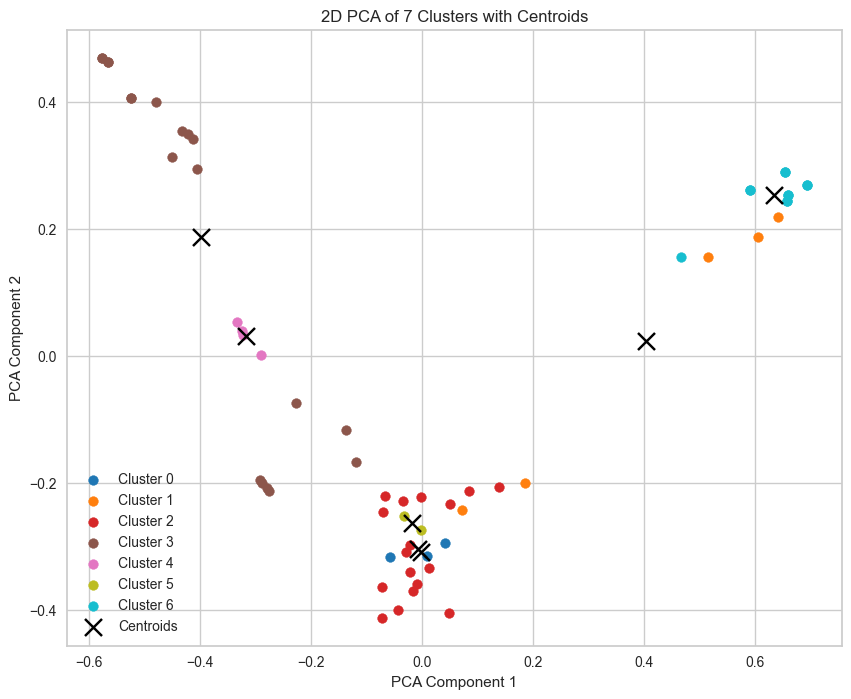

In [83]:
# Cluster and visualize
for i in range(2, 8):
    cluster_and_visualize(tfidf_matrix, k=i)

Based on these resulst, I'll use `k = 4` for two reasons:</br>
1. The groups distribution is better</br>
2. The silhouette score is not so different from `k = 5, 6`

In [84]:
import os

# The chosen number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# Load original data to attach labels
df = pd.read_csv(csv_data_path)
df['Cluster Label'] = cluster_labels

# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'kmeans_cluster_labels.csv')

# Save the DataFrame for further analysis
df.to_csv(csv_path, index=False)

print(f"Data saved to {csv_path}")

Data saved to /Users/tamir_gez/Documents/PythonProjects/HomeAssignmentML/data_files/kmeans_cluster_labels.csv


### 3.2 K-Means using different embeddings

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_and_visualize(embeddings, k, title):
    """
    Cluster the given embeddings using K-Means and visualize the clusters.

    Parameters:
    embeddings (np.ndarray): The embeddings matrix to be clustered.
    k (int): The number of clusters to create.
    title (str): Title for the plot to identify the embedding type.
    
    Returns:
    None. The function only prints the average silhouette score and visualizes the clusters in a 2D plot.
    """
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    
    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    print(f"For {k} clusters, the average silhouette score is: {100*silhouette_avg:.2f}%")
    
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(embeddings)
    reduced_centroids = pca.transform(kmeans.cluster_centers_)
    
    # Create a color map
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], 
                    color=color, label=f'Cluster {i}', alpha=0.7)
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=150, c='black', label='Centroids')
    plt.title(f'2D PCA of {k} Clusters with Centroids: {title}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best')
    plt.show()


For 2 clusters, the average silhouette score is: 12.25%


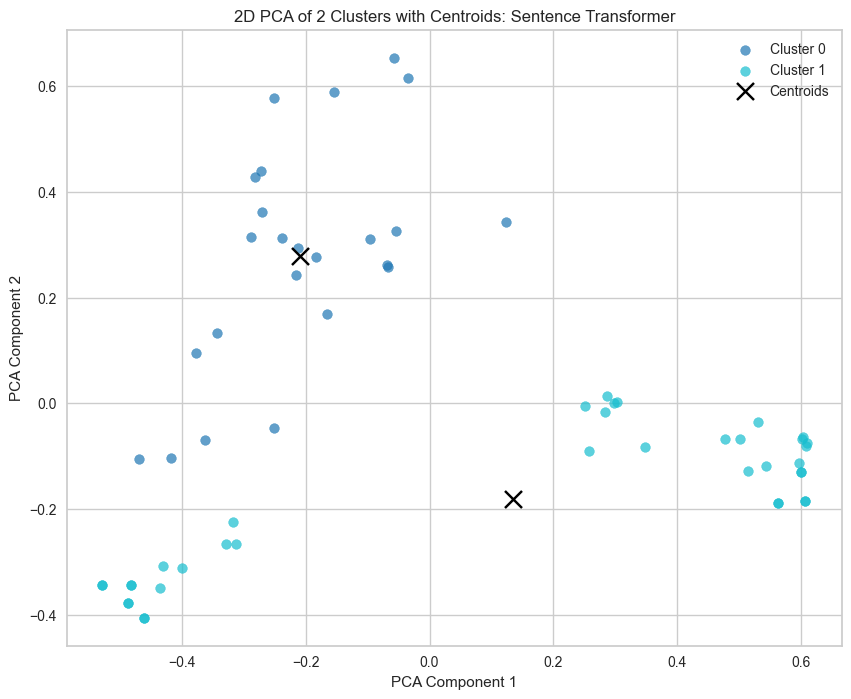

For 3 clusters, the average silhouette score is: 10.96%


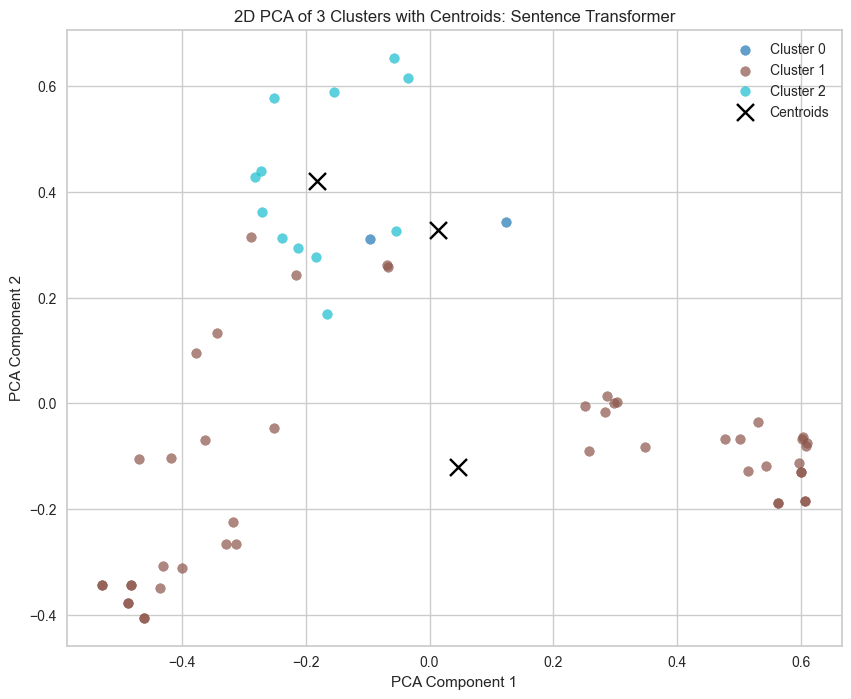

For 4 clusters, the average silhouette score is: 21.02%


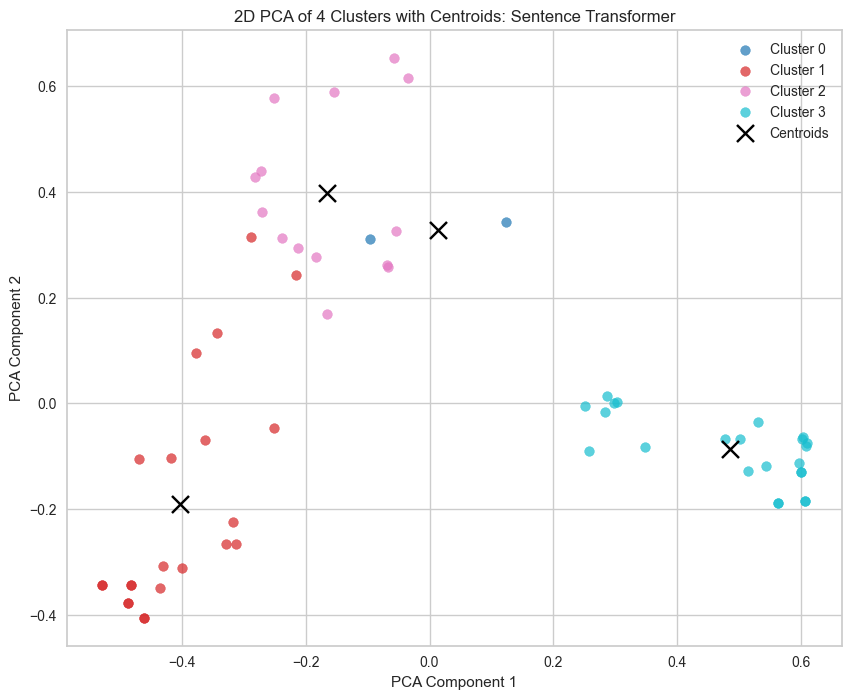

For 5 clusters, the average silhouette score is: 21.23%


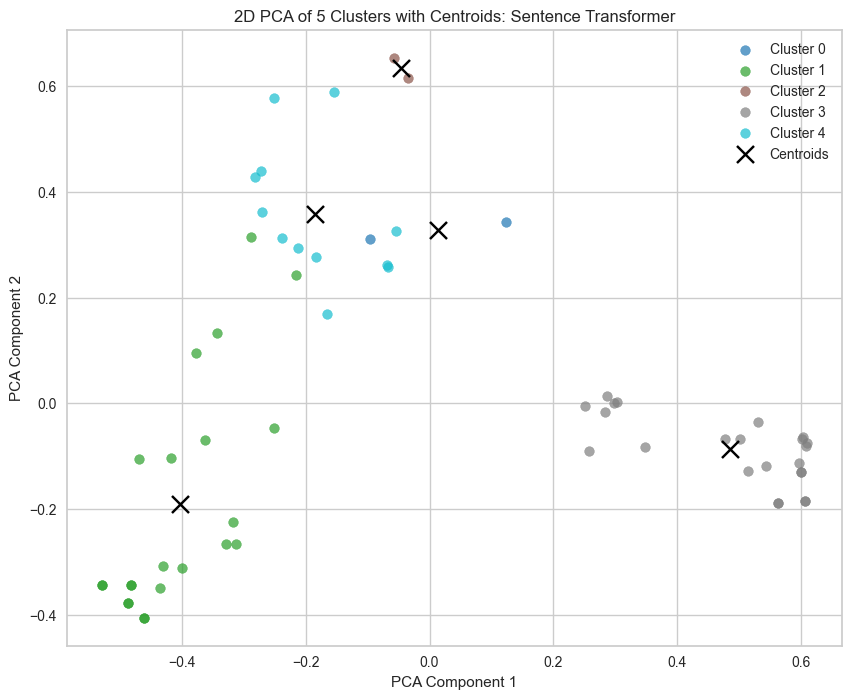

For 6 clusters, the average silhouette score is: 19.99%


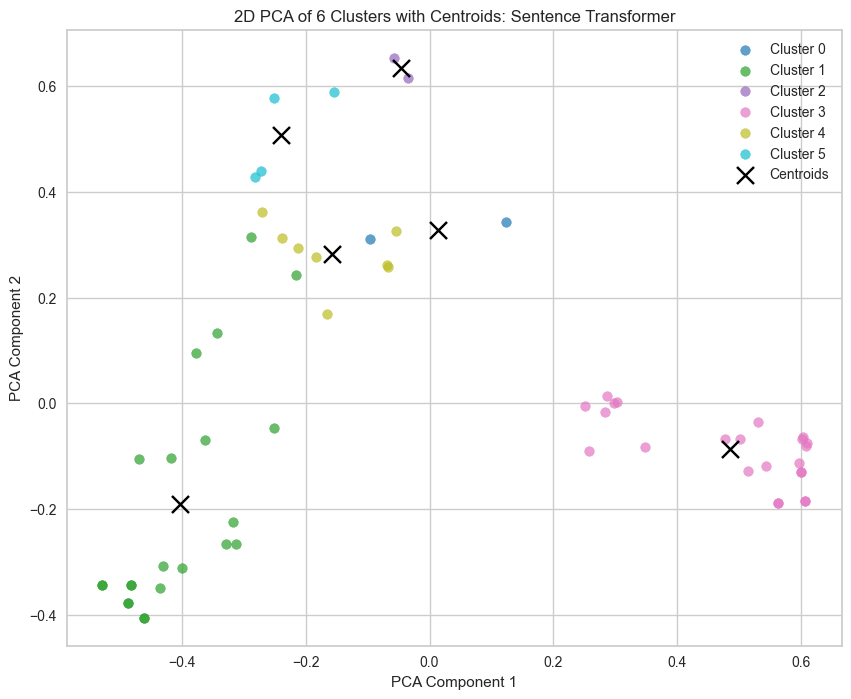

For 7 clusters, the average silhouette score is: 16.58%


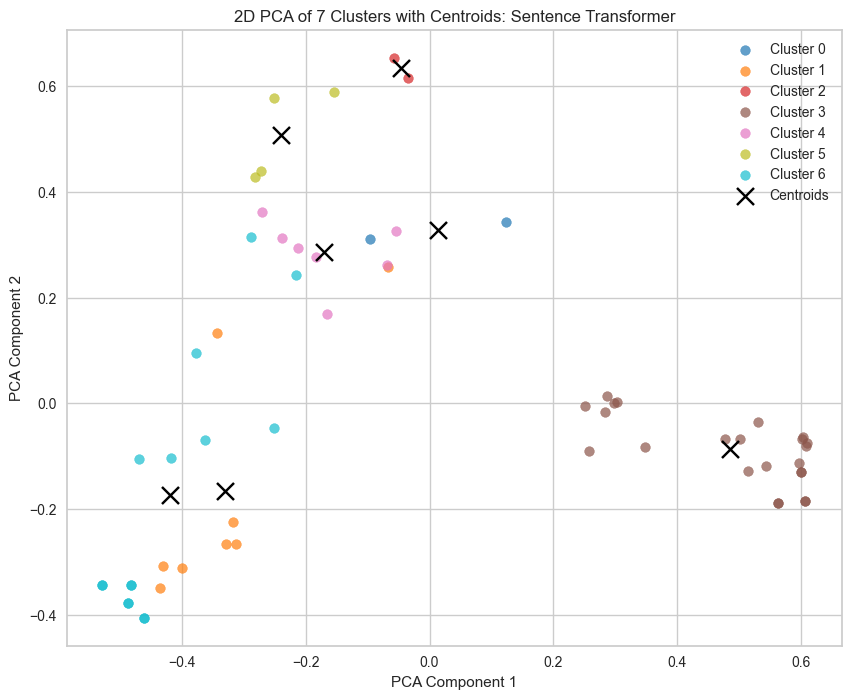

In [86]:
# Cluster and visualize
for k in range(2, 8):
    cluster_and_visualize(np.stack(df_embeddings['Sentence Transformer Embedding'].values), k, 'Sentence Transformer')

For 2 clusters, the average silhouette score is: 20.85%


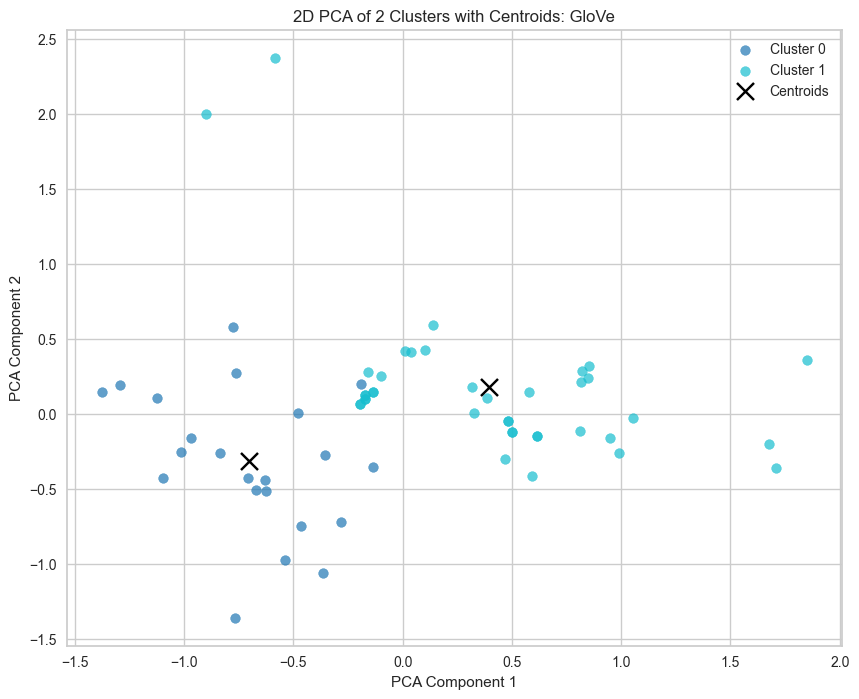

For 3 clusters, the average silhouette score is: 21.85%


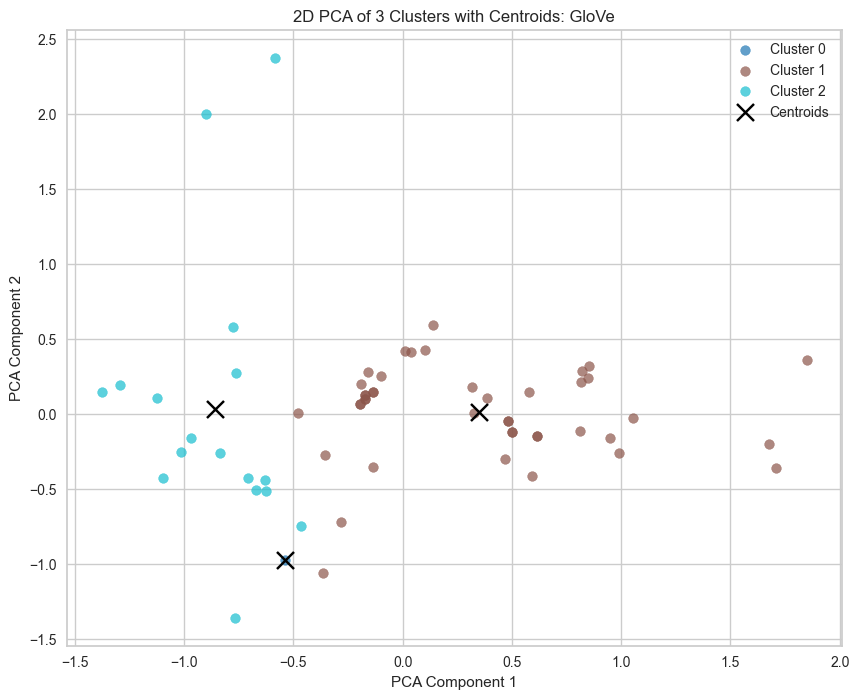

For 4 clusters, the average silhouette score is: 20.13%


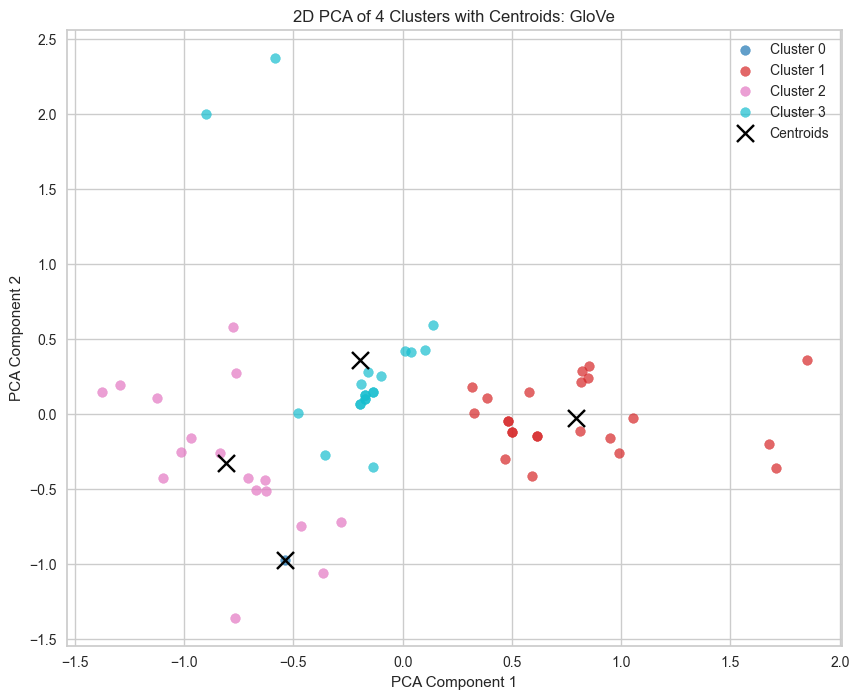

For 5 clusters, the average silhouette score is: 23.57%


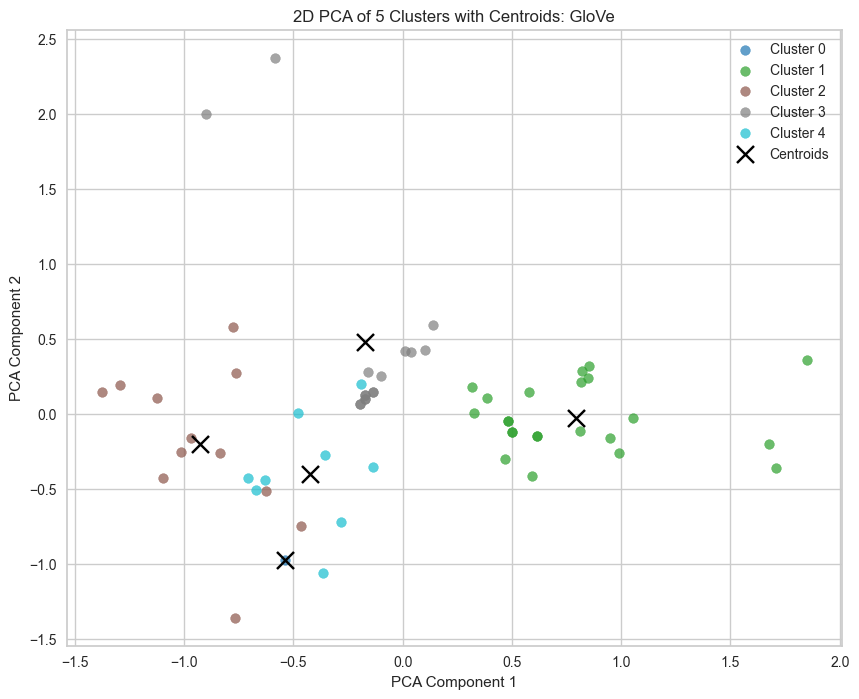

For 6 clusters, the average silhouette score is: 23.67%


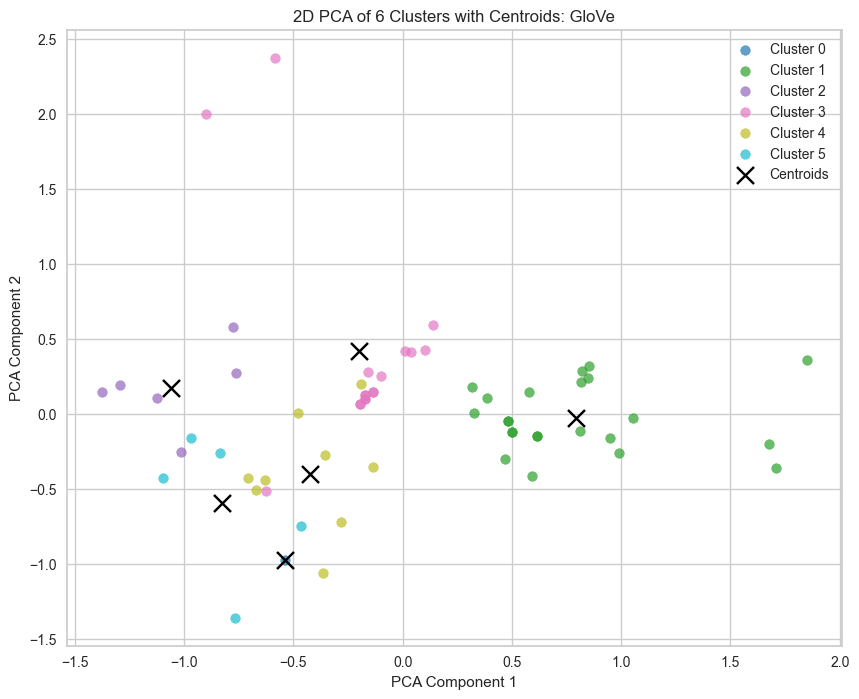

For 7 clusters, the average silhouette score is: 24.62%


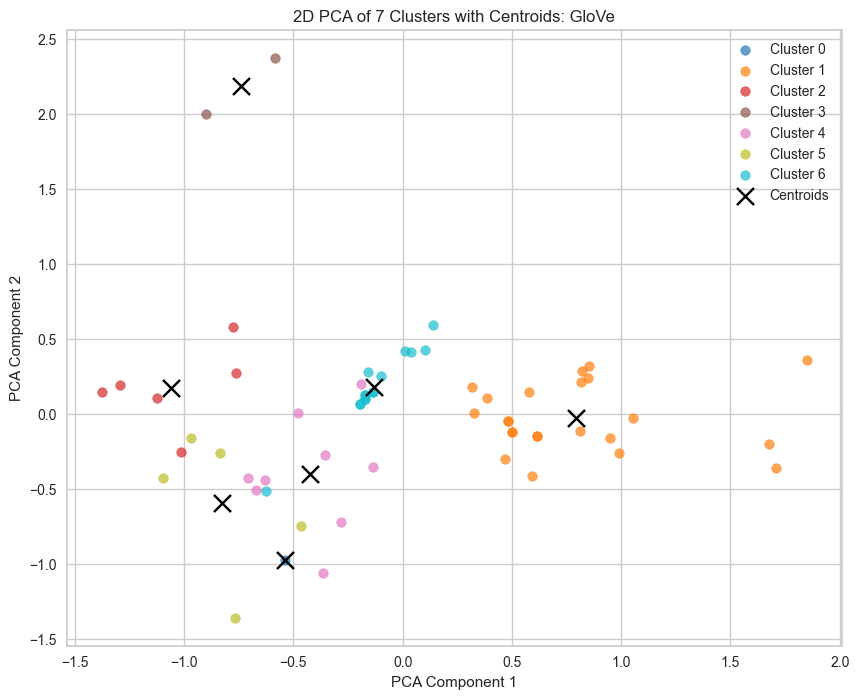

In [87]:
for k in range(2, 8):
    cluster_and_visualize(np.stack(df_embeddings['GloVe Embedding'].values), k, 'GloVe')

For 2 clusters, the average silhouette score is: 18.57%


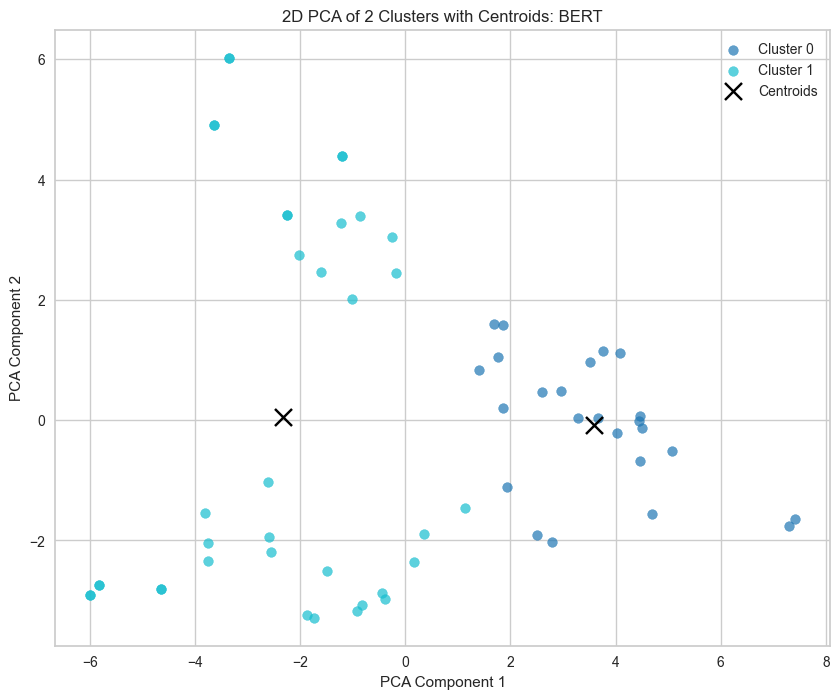

For 3 clusters, the average silhouette score is: 10.06%


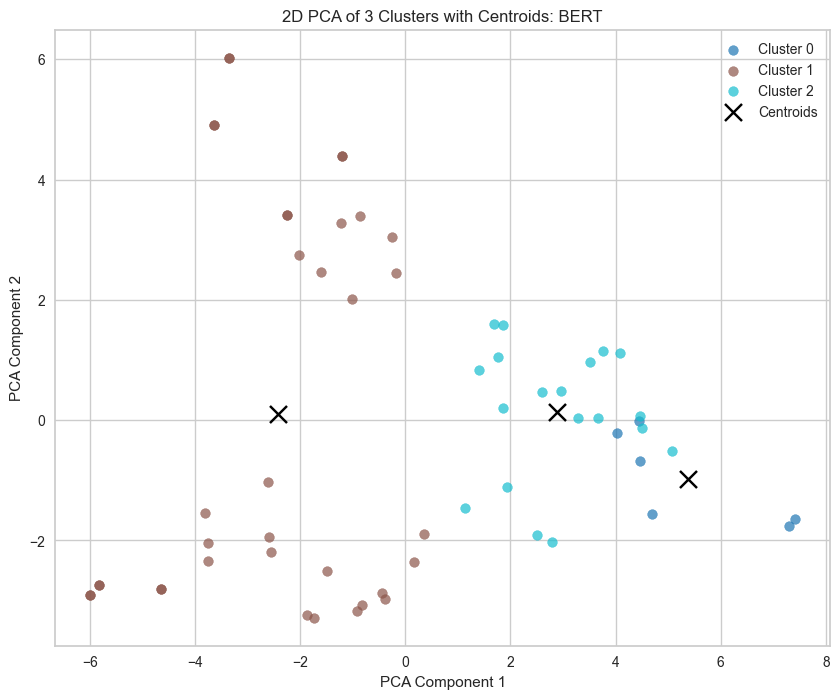

For 4 clusters, the average silhouette score is: 8.49%


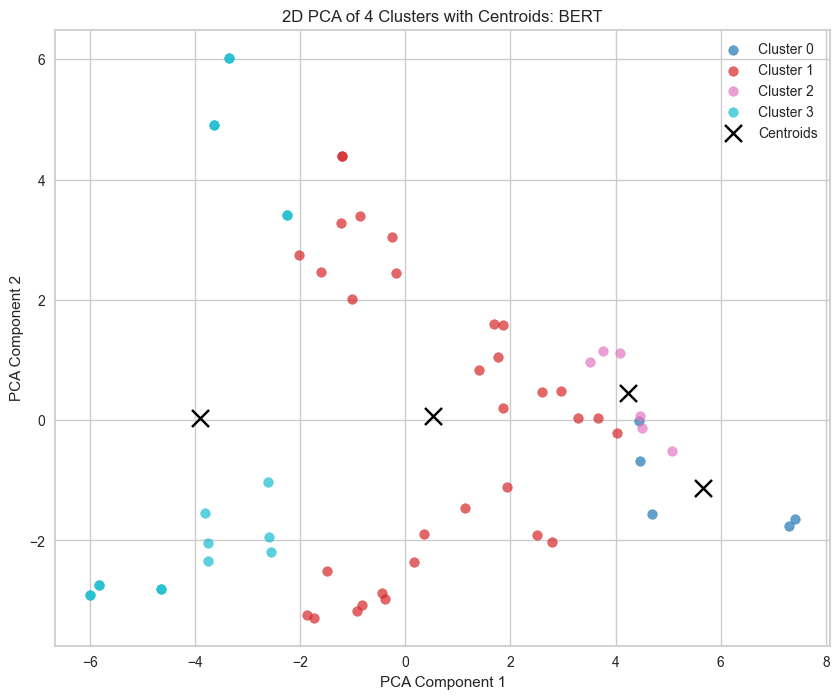

For 5 clusters, the average silhouette score is: 9.88%


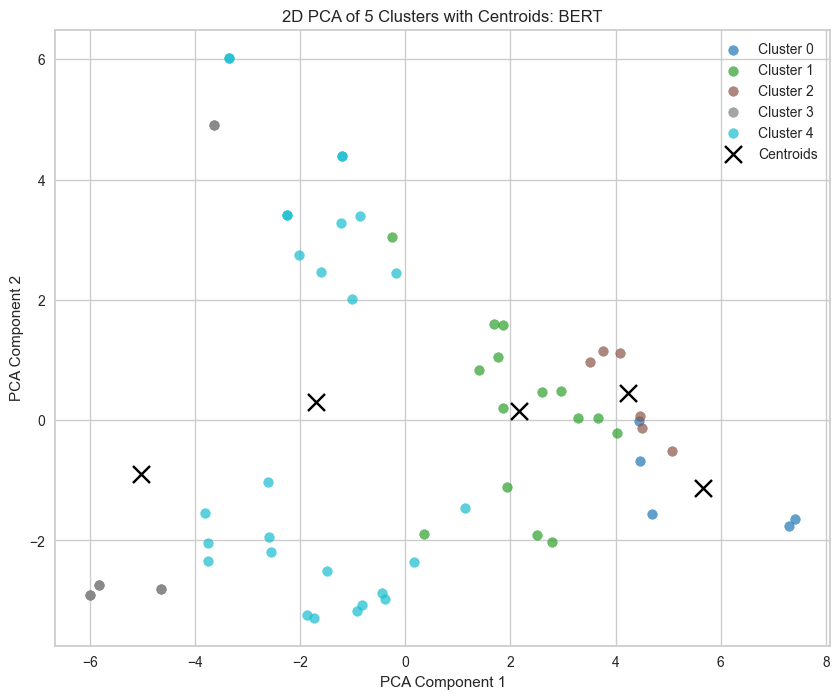

For 6 clusters, the average silhouette score is: 9.34%


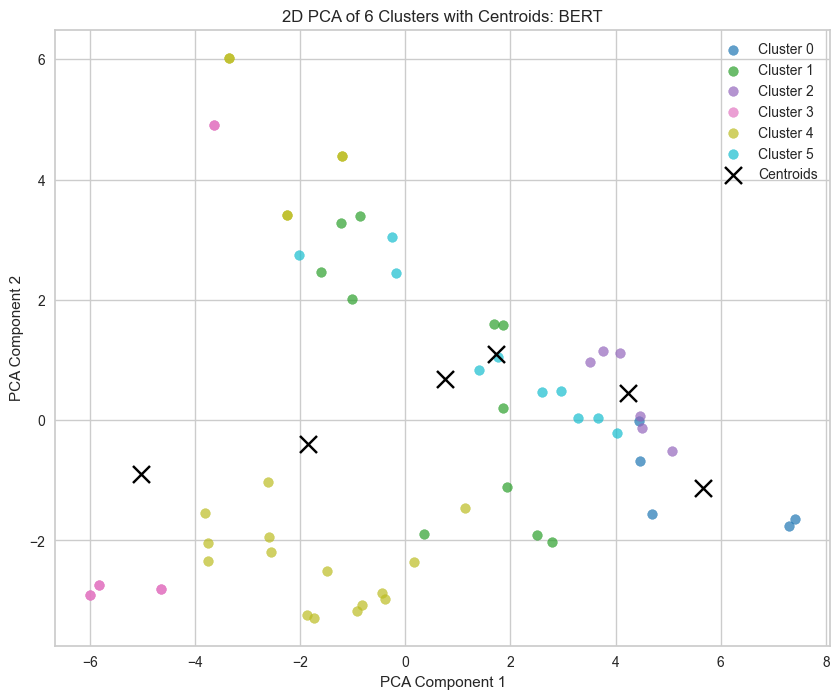

For 7 clusters, the average silhouette score is: 17.51%


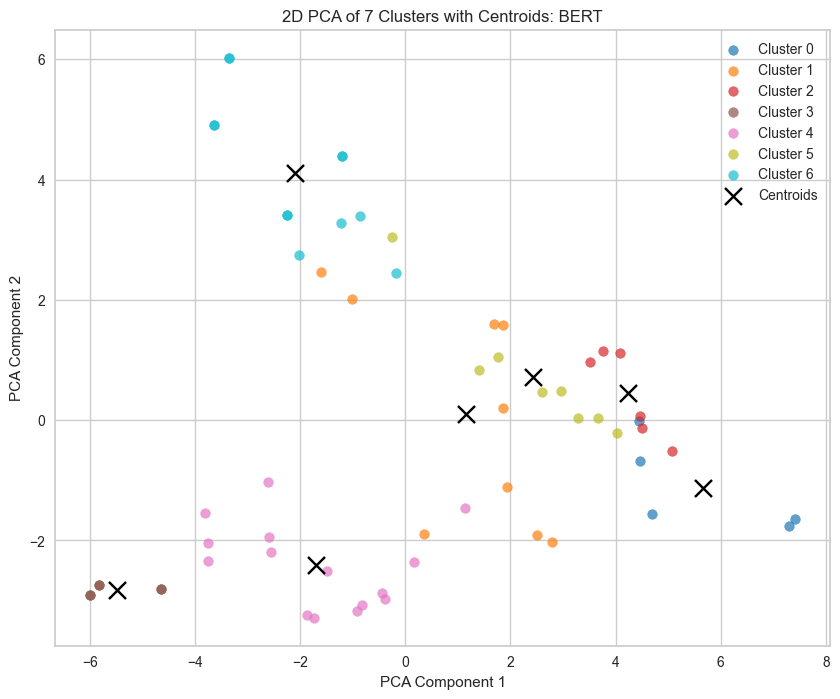

In [88]:
for k in range(2, 8):
    cluster_and_visualize(np.stack(df_embeddings['BERT Embedding'].values), k, 'BERT')

For 2 clusters, the average silhouette score is: 43.20%


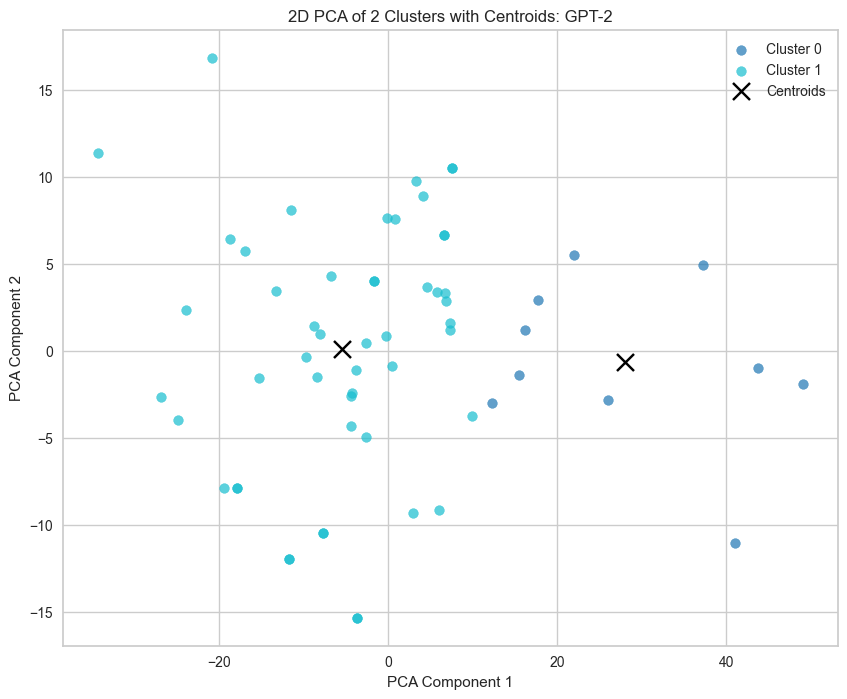

For 3 clusters, the average silhouette score is: 30.05%


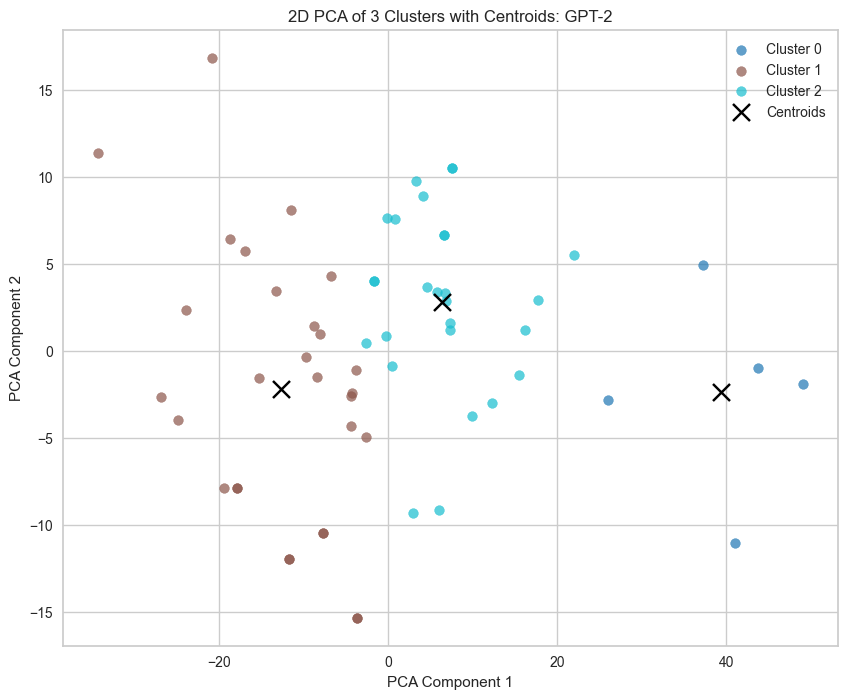

For 4 clusters, the average silhouette score is: 24.50%


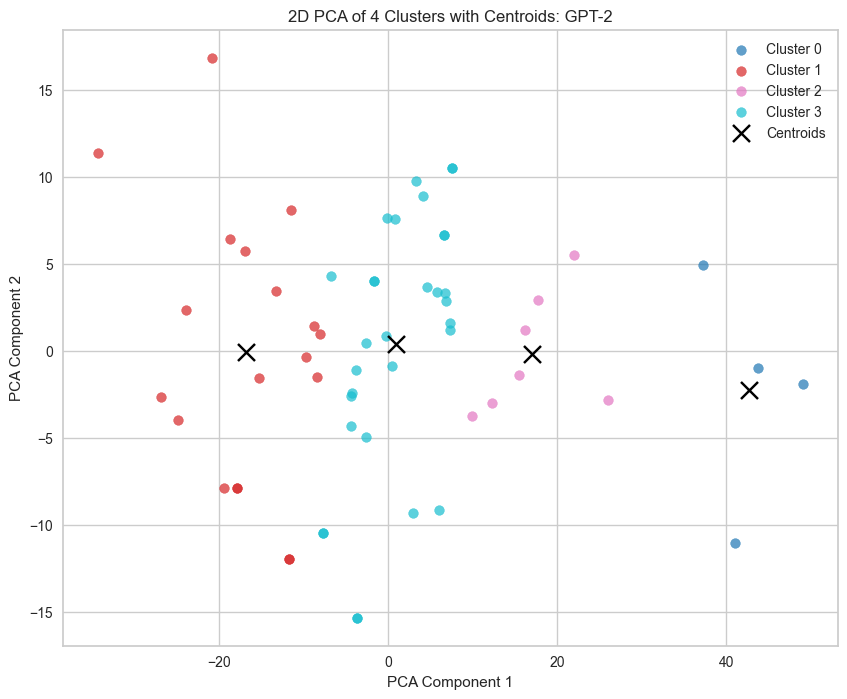

For 5 clusters, the average silhouette score is: 25.51%


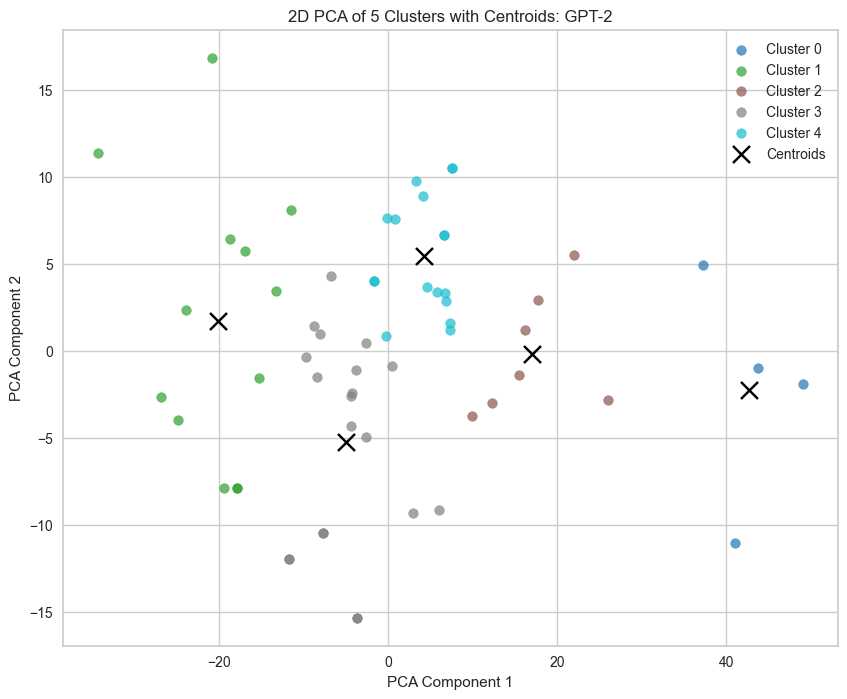

For 6 clusters, the average silhouette score is: 26.35%


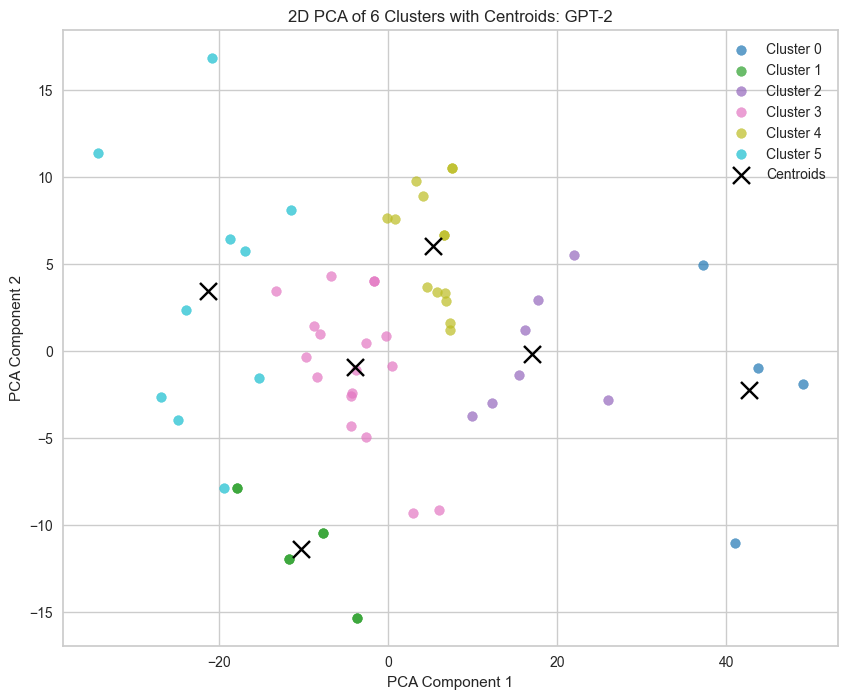

For 7 clusters, the average silhouette score is: 22.53%


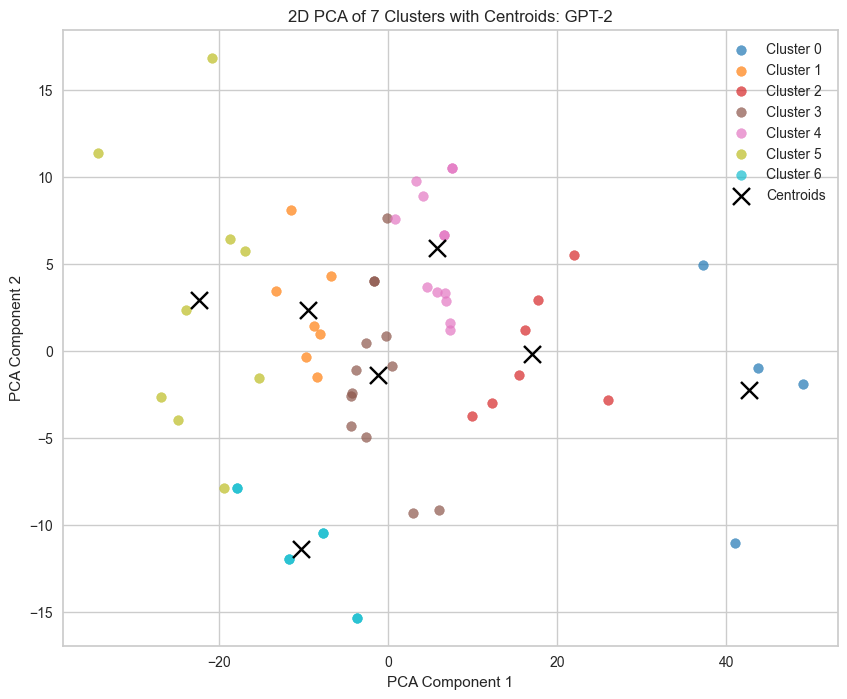

In [89]:
for k in range(2, 8):
    cluster_and_visualize(np.stack(df_embeddings['GPT-2 Embedding'].values), k, 'GPT-2')

### 3.3 Hierarchical Clustering using TF-IDF

* __Linkage__ is a rule used in hierarchical clustering to decide how to measure the distance between groups of observations. It helps determine how clusters are formed by specifying which data points should be joined together as clustering progresses.</br>
    * __Single Linkage__: The distance between two clusters is defined as the shortest distance between points in the two clusters.
    * __Complete Linkage__: The distance between two clusters is defined as the longest distance between points in the two clusters.
    * __Average Linkage__: The distance between two clusters is the average distance between all pairs of points in the clusters.
    * __Ward’s Linkage__: The distance between two clusters is the increase in the total within-cluster variance after merging them.</br>

* A __dendrogram__ is a tree-like diagram that shows how different groups or data points come together to form clusters in hierarchical clustering. It visually displays the relationships between clusters, with each branch representing a merge of clusters, and the length of the branches showing how different or similar the merged clusters are.


In [90]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import load_npz

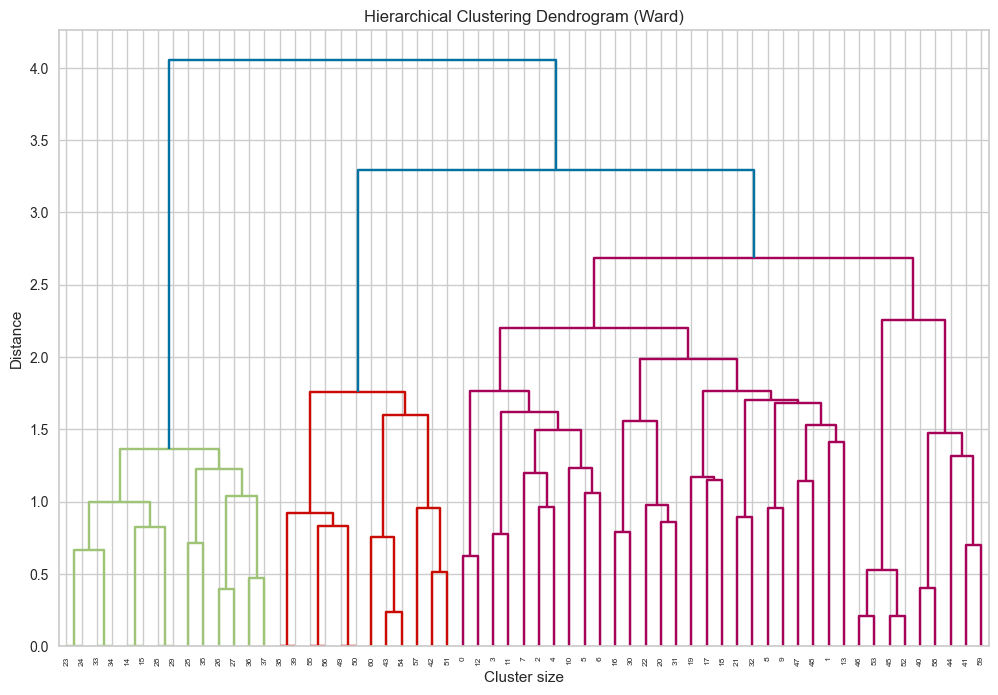

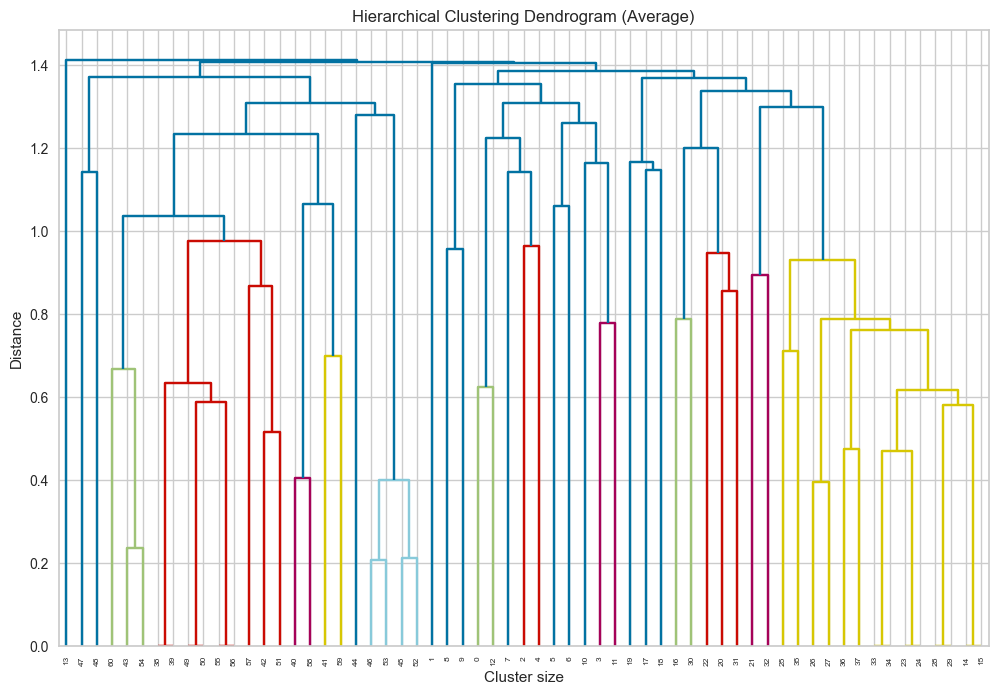

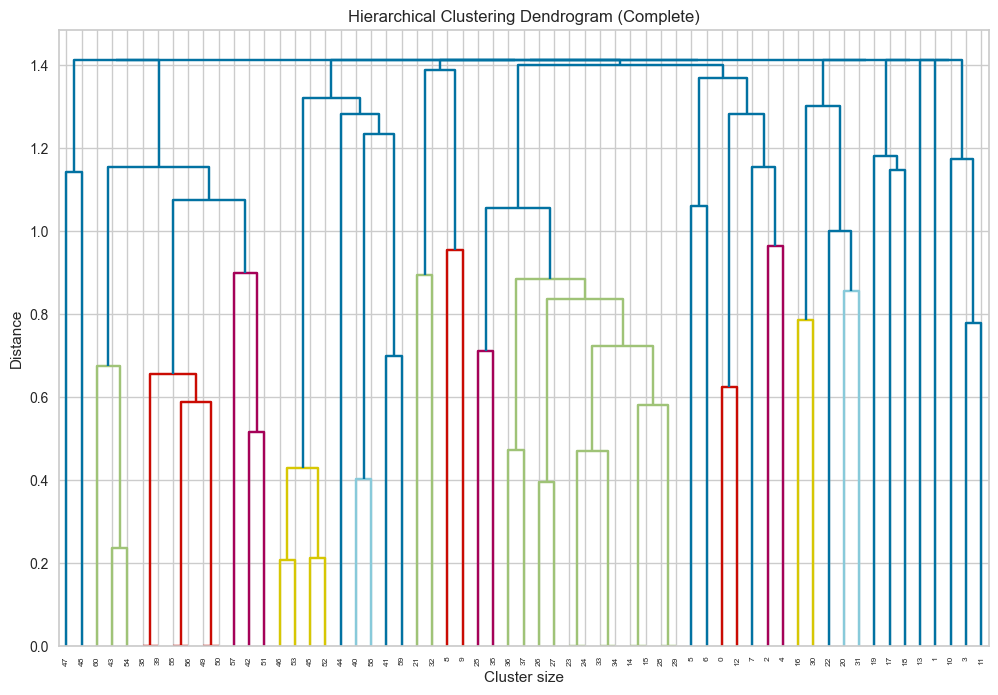

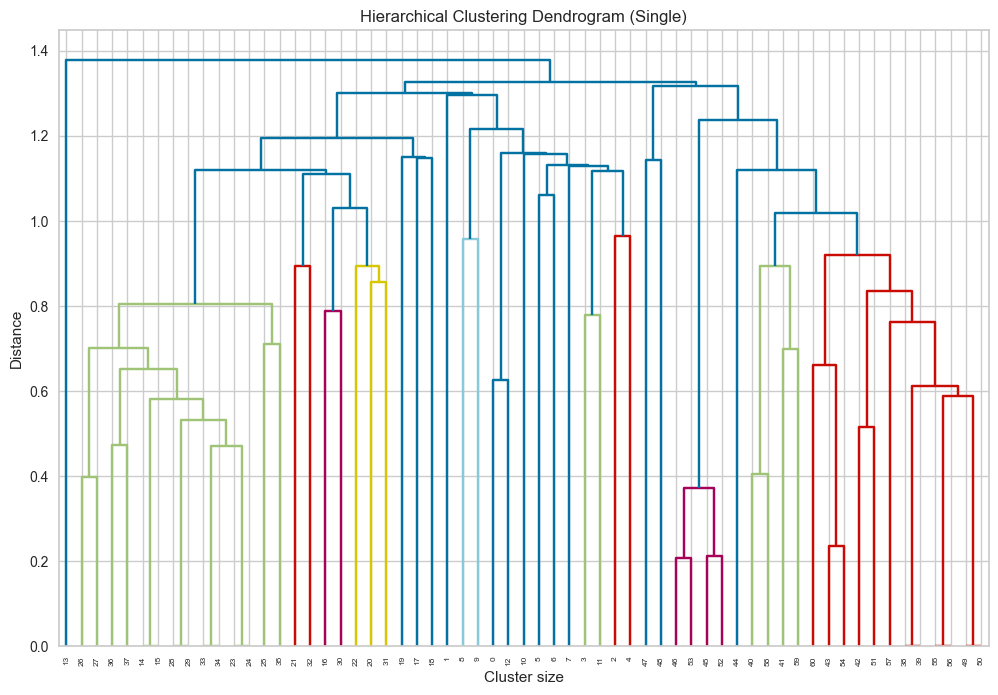

In [91]:
# Load the TF-IDF matrix
tfidf_matrix = load_npz(matrix_path)

# Define the linkage methods
methods = 'ward', 'average', 'complete', 'single'

# Iterate over the linkage methods
for method in methods:
    
    # Compute the linkage matrix
    Z = linkage(tfidf_matrix.toarray(), method=method)

    # Plot the dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(Z)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()})')
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    plt.show()

Based on the graphs, it will be best to choose the `ward` method thanks to 2-5 distinct vertical lines.

In [92]:

# Cutting the dendrogram and extract the clusters labels
from scipy.cluster.hierarchy import fcluster

# The chosen number of clusters
k = 4

# Apply the fcluster function to cut the dendrogram at the determined number of clusters
cluster_labels = fcluster(Z, k, criterion='maxclust')

# Load original data to attach labels
df = pd.read_csv(csv_data_path)

# Add cluster label to original dataframe
df['Cluster Label'] = cluster_labels

# Group the data by cluster label
grouped_texts = df.groupby('Cluster Label')['Normalized Claim'].apply(list)

# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'hierarchical_cluster_labels.csv')

# Save the DataFrame for further analysis
df.to_csv(csv_path, index=False)

print(f"Data saved to {csv_path}")

Data saved to /Users/tamir_gez/Documents/PythonProjects/HomeAssignmentML/data_files/hierarchical_cluster_labels.csv


### 3.4 Hierarchical Clustering using different embeddings

In [93]:
def hierarchical_clustering_and_plot(embeddings, methods, title):
    """
    Perform hierarchical clustering on given embeddings and plot the dendrogram for each method.

    Parameters:
    embeddings (np.ndarray): The embeddings to be clustered.
    methods (tuple): A tuple of strings representing the linkage methods to use.
    title (str): Title for the plot to identify the embedding type.
    
    Returns:
    None. The function visualizes the dendrogram for each linkage method.
    """
    # Iterate over the linkage methods
    for method in methods:
        # Compute the linkage matrix
        Z = linkage(embeddings, method=method)

        # Plot the dendrogram
        plt.figure(figsize=(12, 8))
        dendrogram(Z)
        plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()}) - {title}')
        plt.xlabel('Cluster size')
        plt.ylabel('Distance')
        plt.show()


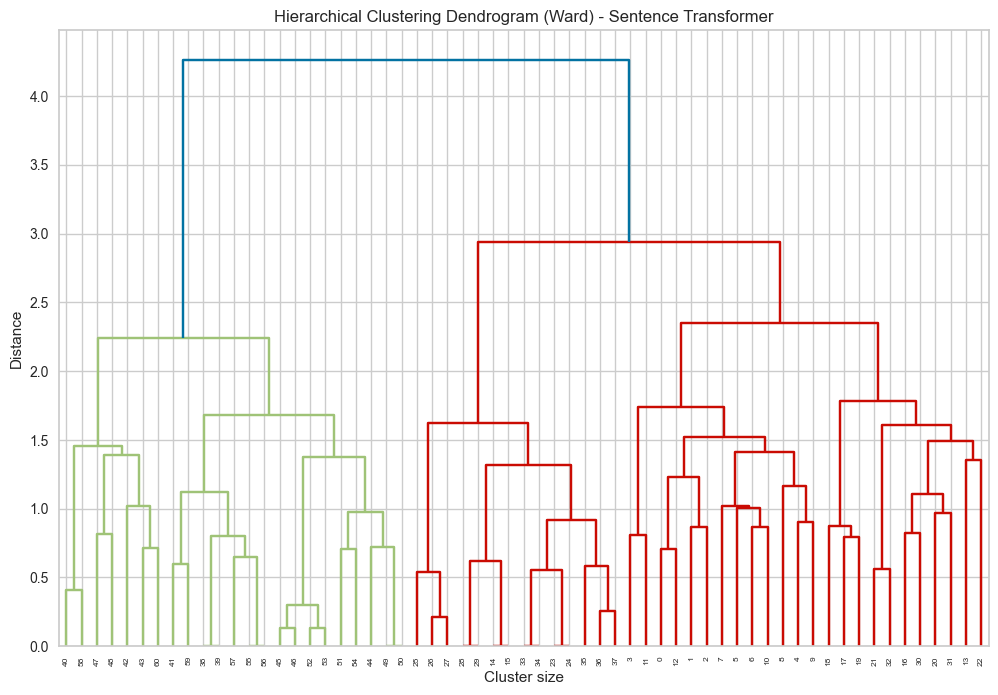

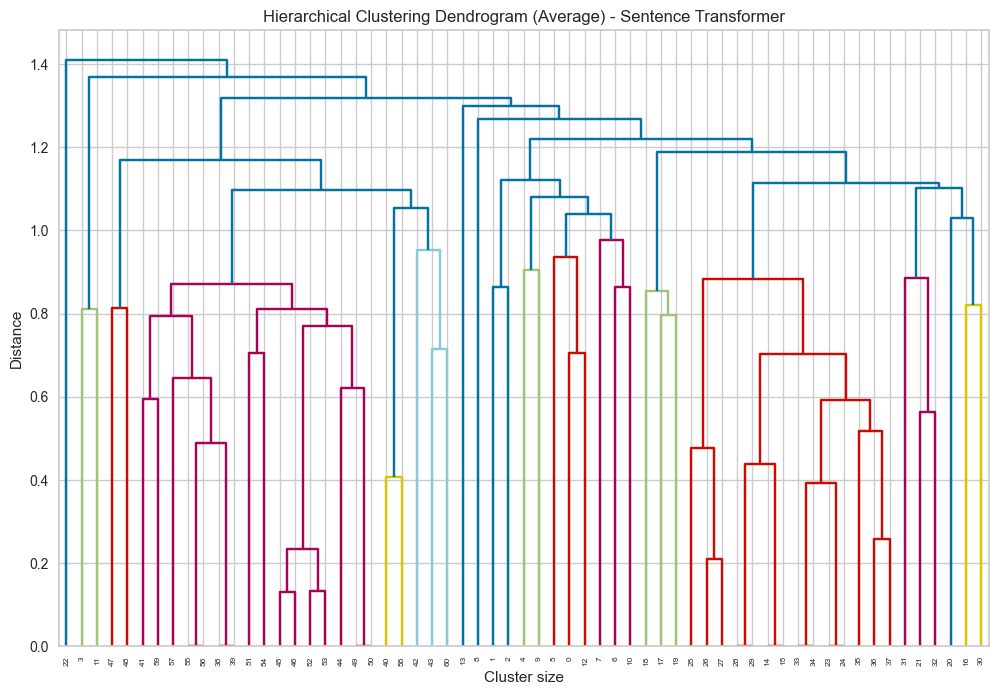

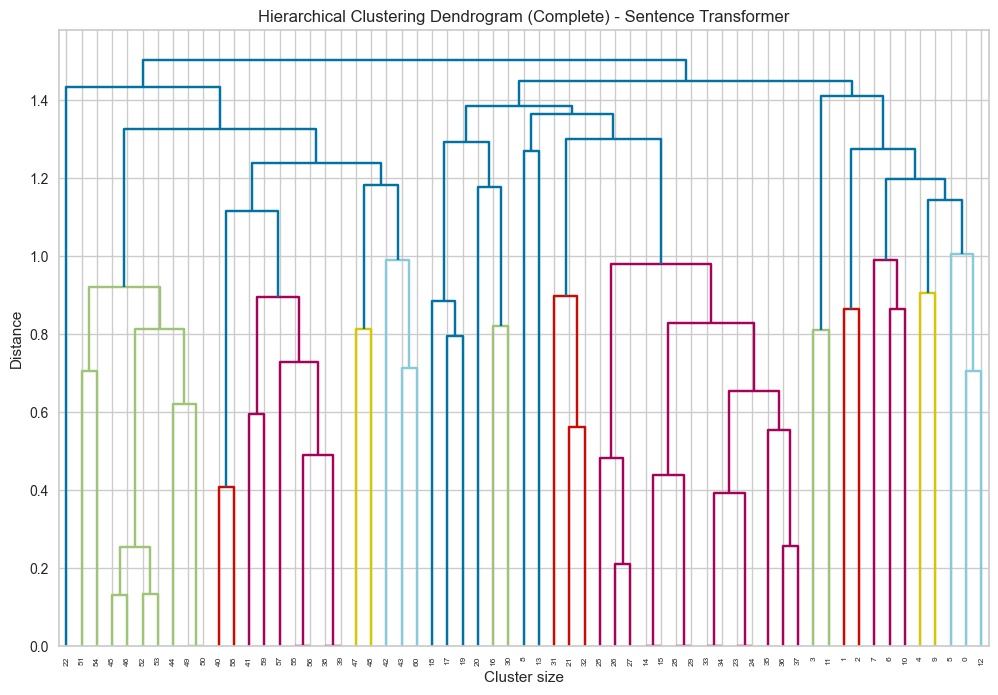

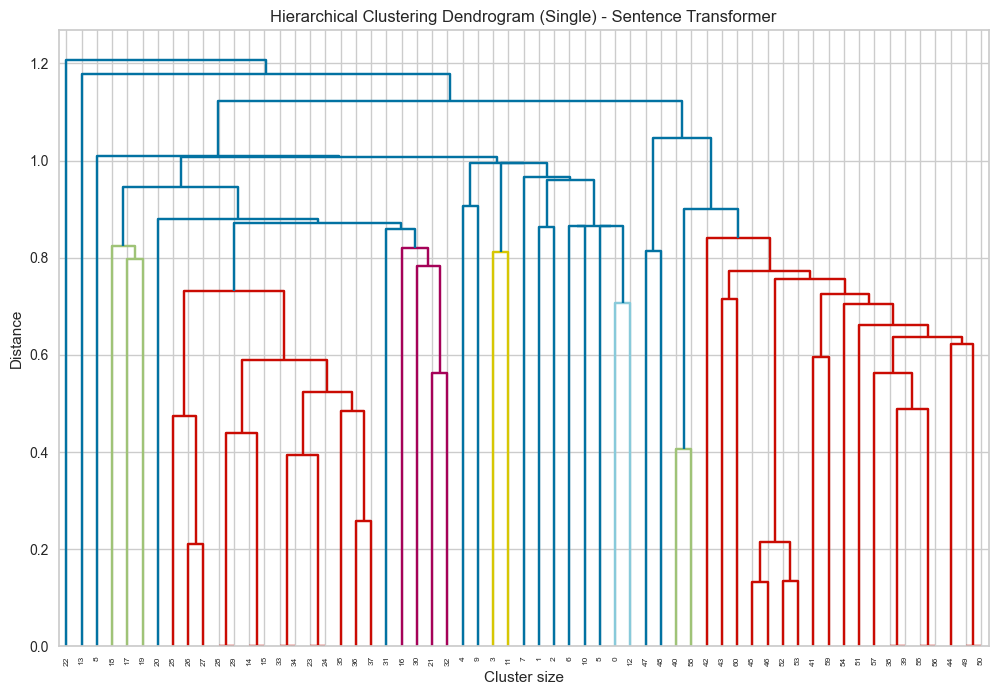

In [103]:
# Define the linkage methods
methods = 'ward', 'average', 'complete', 'single'

# Example usage with each type of embedding
hierarchical_clustering_and_plot(np.stack(df_embeddings['Sentence Transformer Embedding'].values), methods, 'Sentence Transformer')

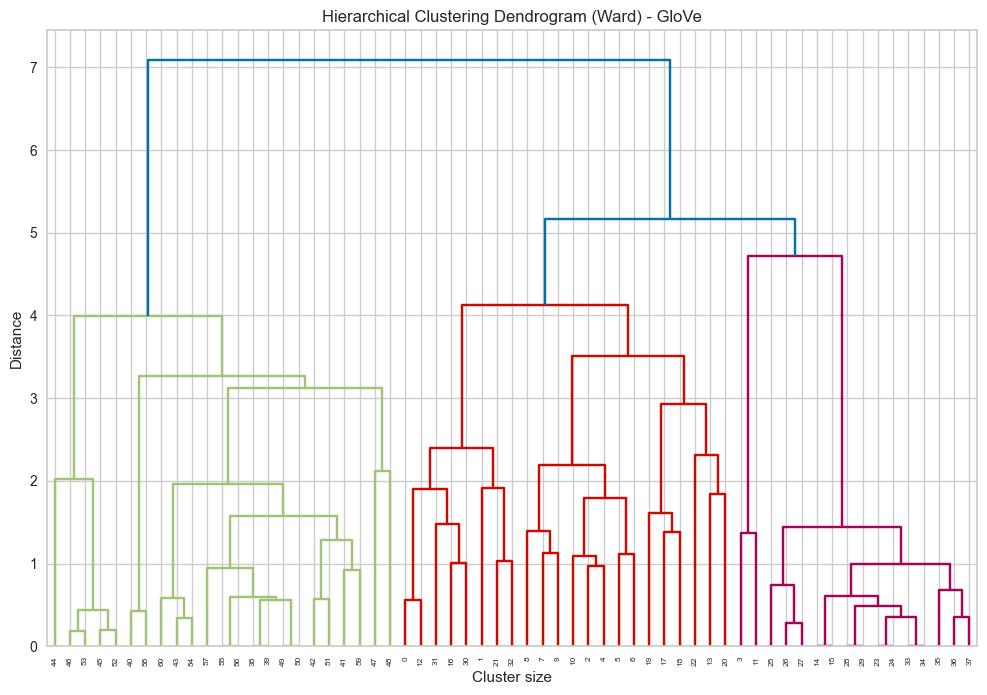

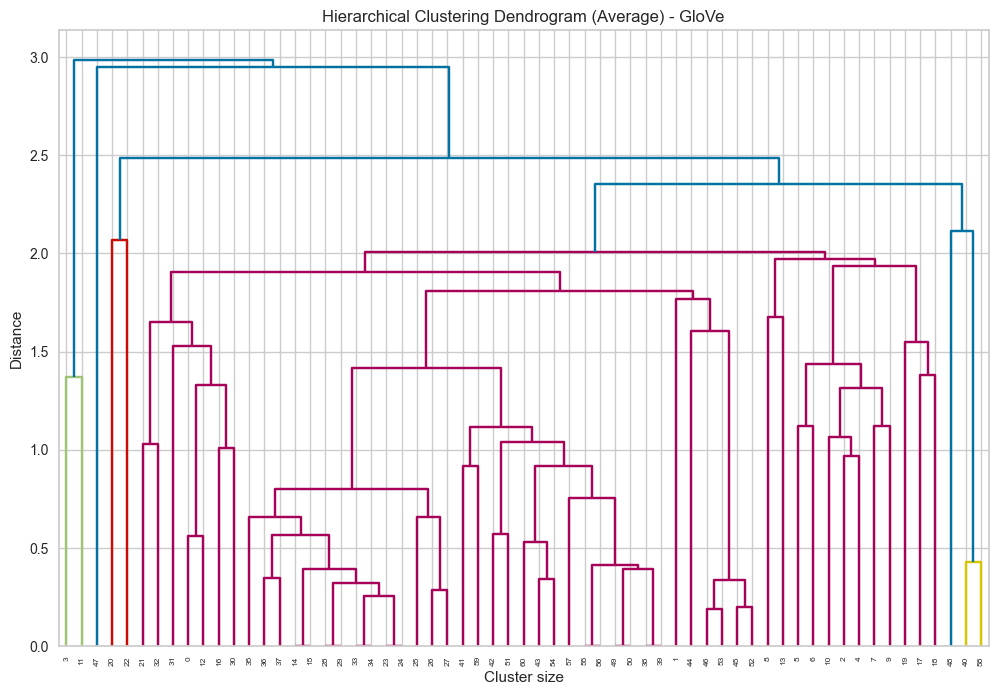

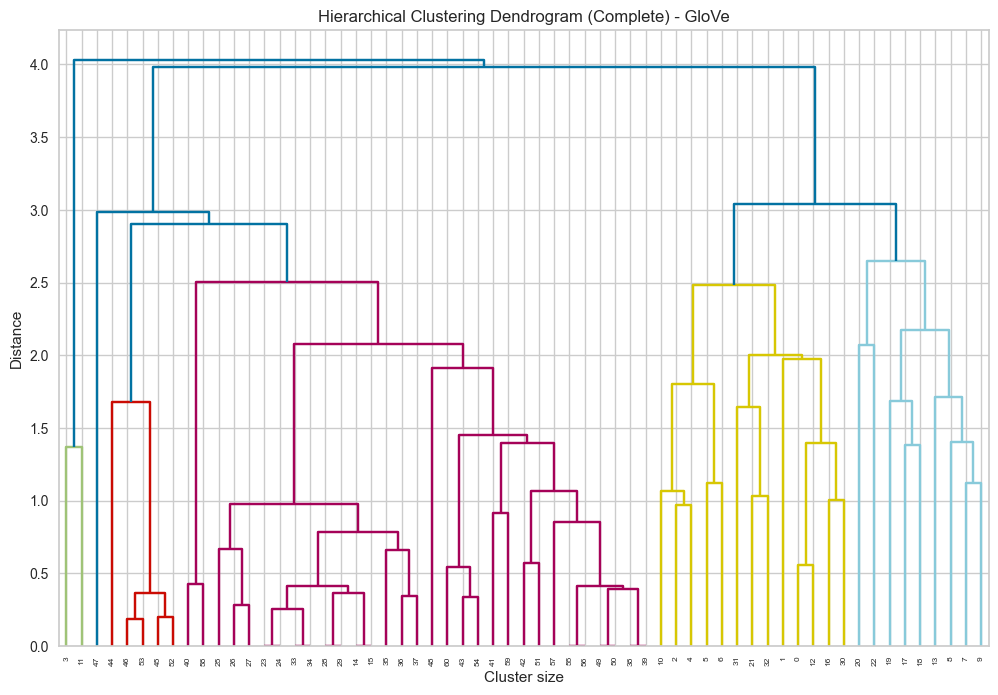

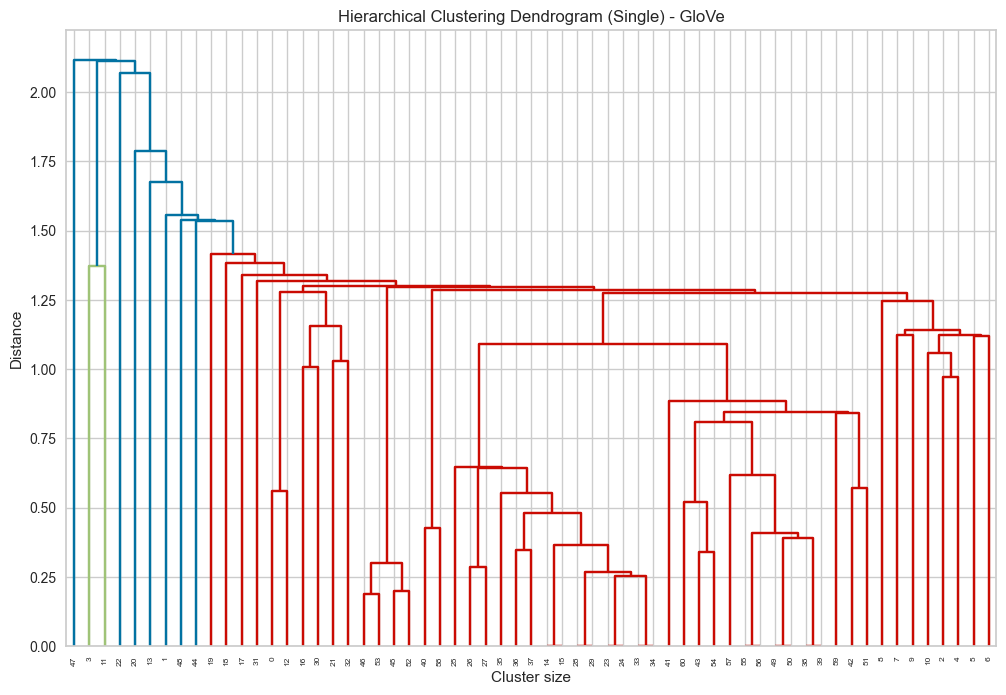

In [104]:
hierarchical_clustering_and_plot(np.stack(df_embeddings['GloVe Embedding'].values), methods, 'GloVe')

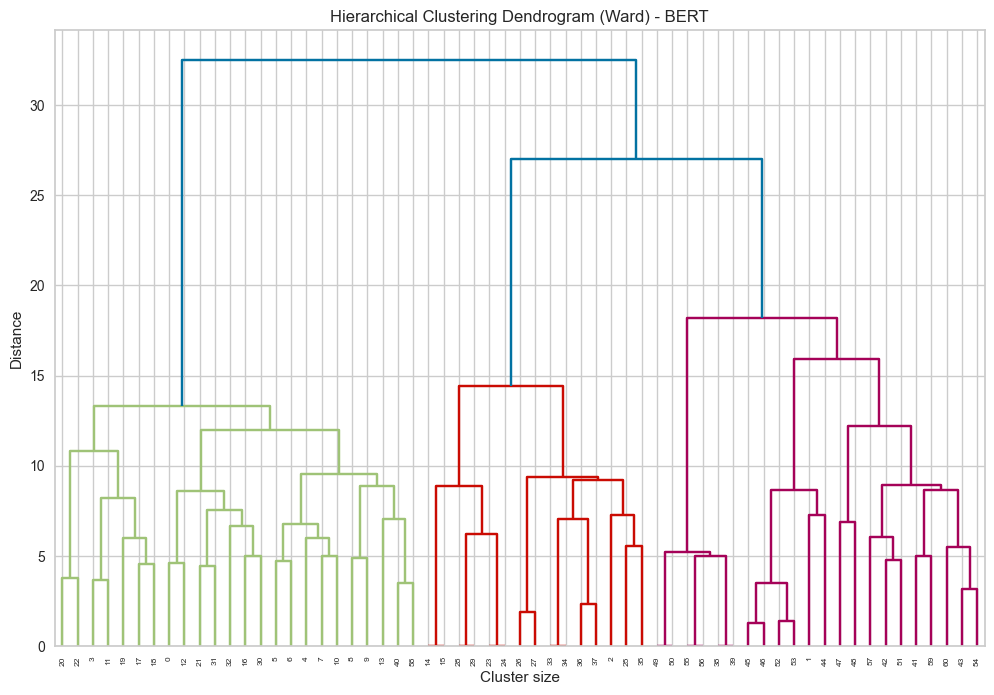

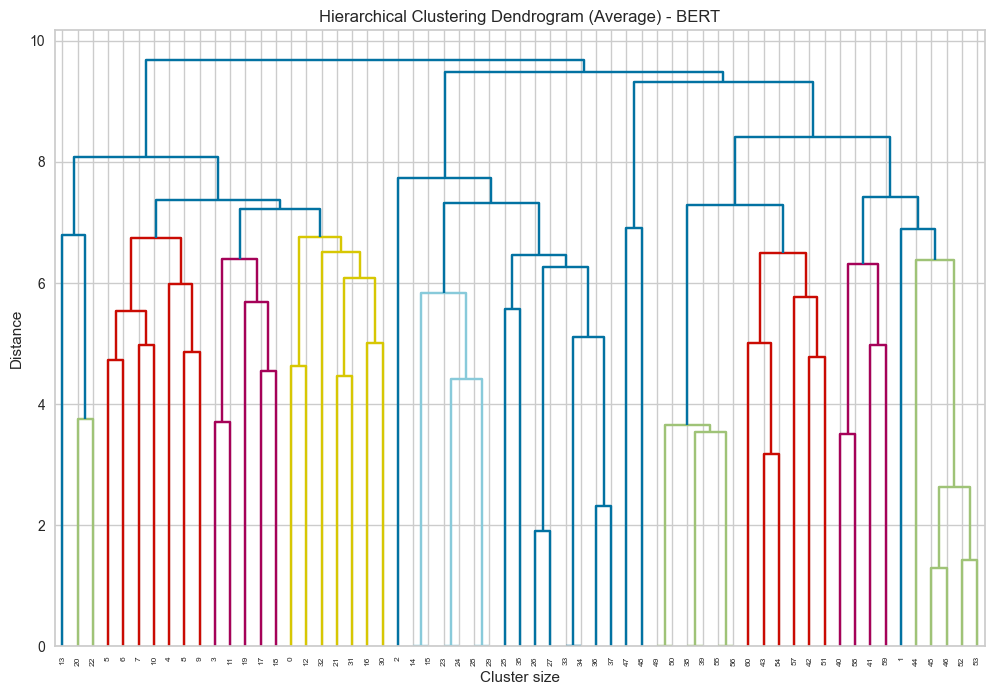

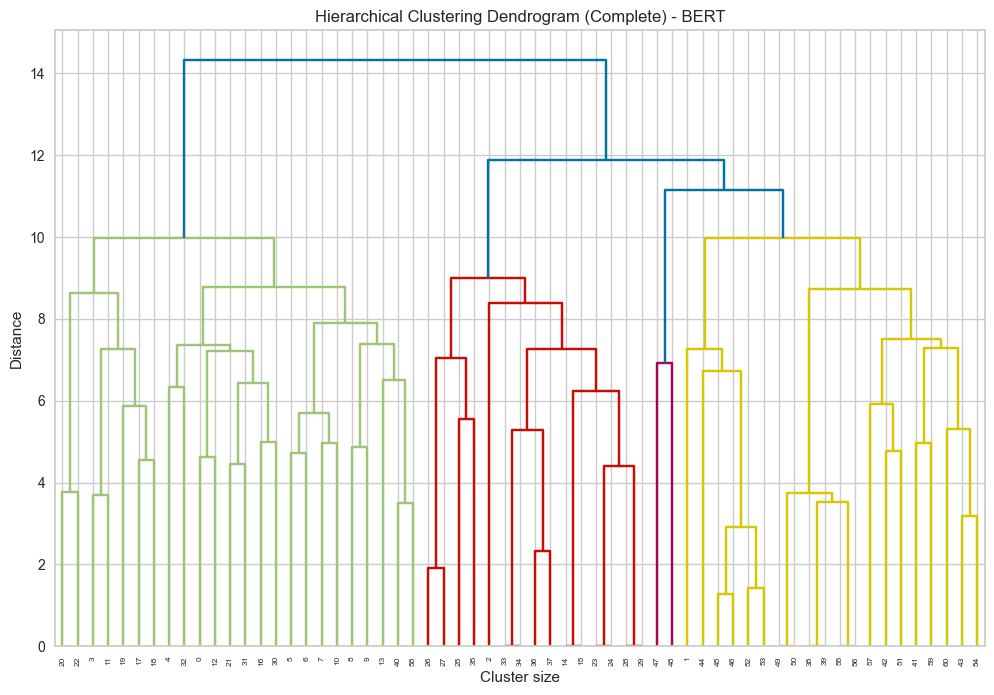

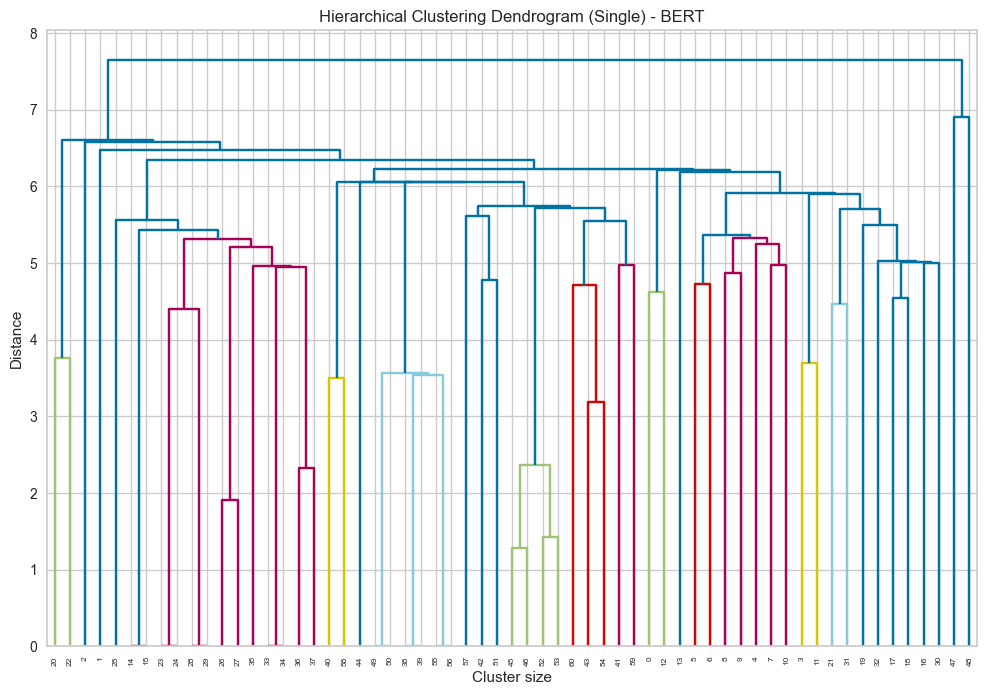

In [105]:
hierarchical_clustering_and_plot(np.stack(df_embeddings['BERT Embedding'].values), methods, 'BERT')

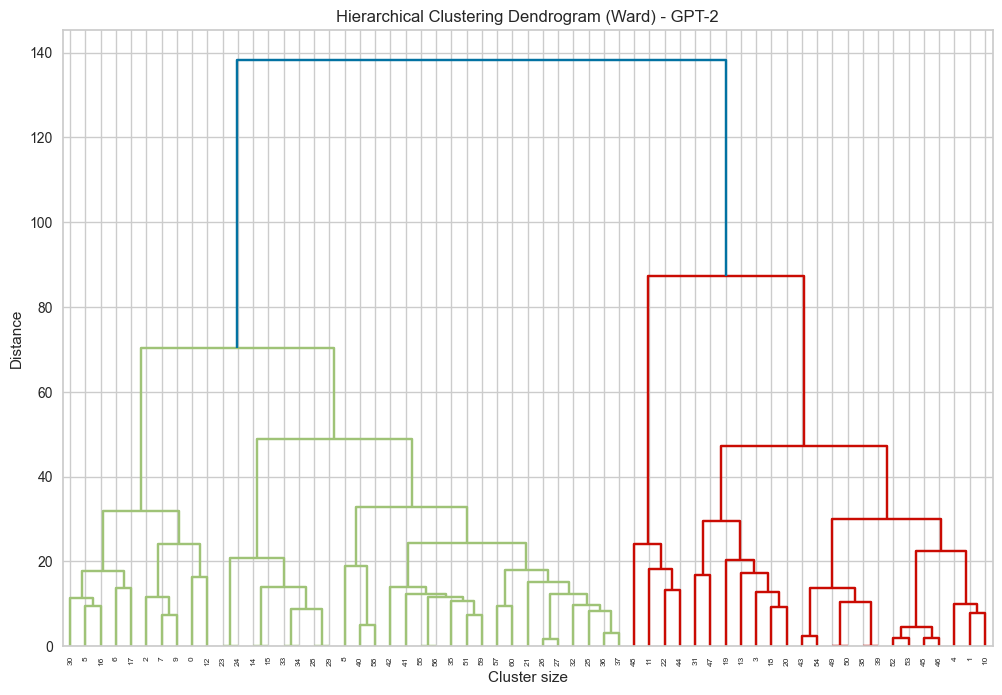

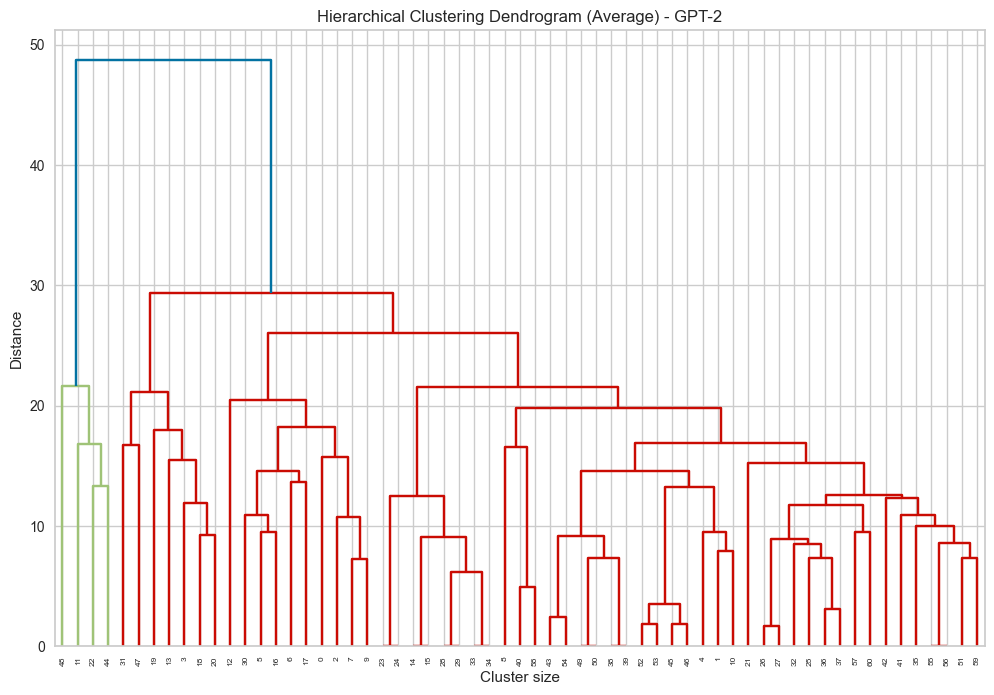

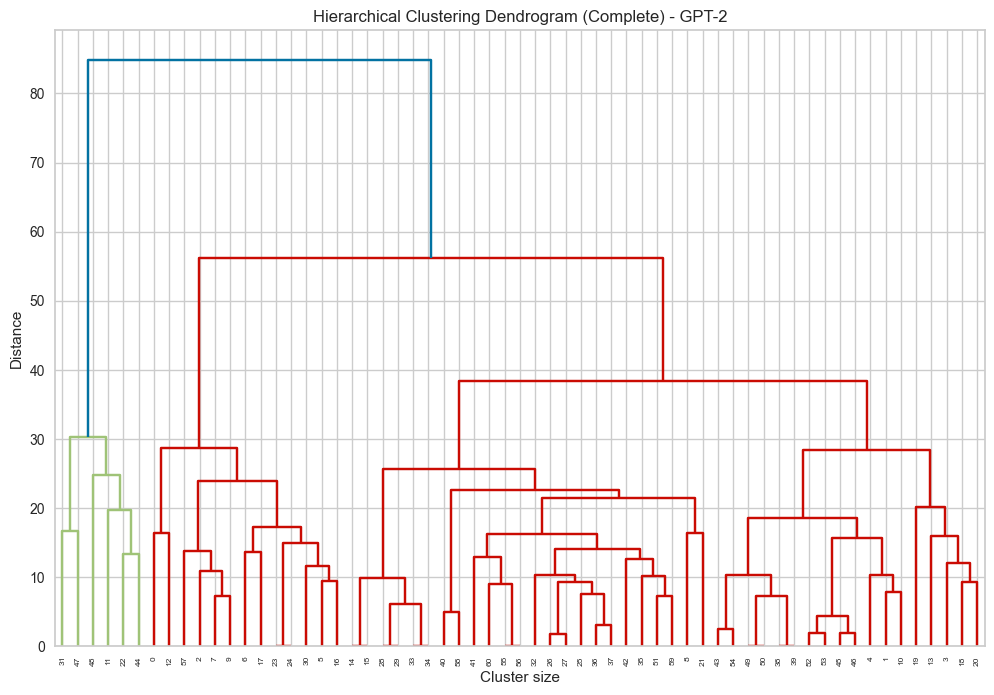

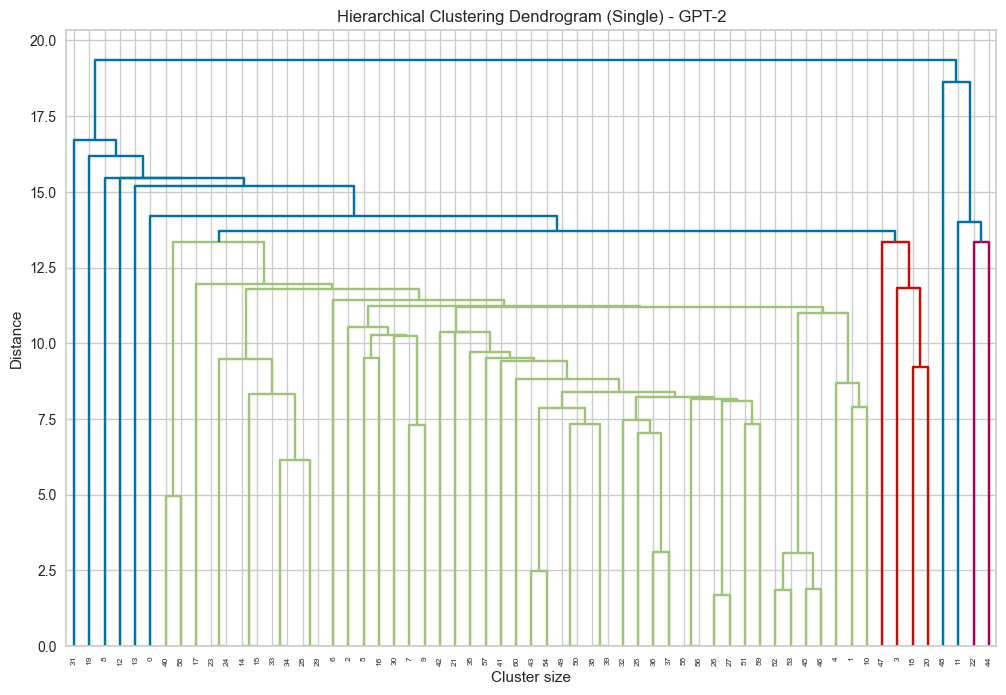

In [106]:
hierarchical_clustering_and_plot(np.stack(df_embeddings['GPT-2 Embedding'].values), methods, 'GPT-2')

In [98]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import os

# Extract GPT-2 Embeddings and convert them to a numpy array
gpt2_embeddings = np.stack(df_embeddings['GPT-2 Embedding'].values)

# Perform KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(gpt2_embeddings)
clusters = kmeans.labels_

# Add cluster labels back to the original DataFrame
df_embeddings['Cluster Label'] = clusters

# Get the directory of the current script
current_script_path = os.getcwd()

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'GPT_clustred_patent_claims.csv')

# Save the DataFrame for further analysis
df_embeddings.to_csv(csv_path, index=False)  # Make sure to use df_embeddings or df depending on your DataFrame setup

print(f"Data saved to {csv_path}")


Data saved to /Users/tamir_gez/Documents/PythonProjects/HomeAssignmentML/data_files/GPT_clustred_patent_claims.csv


### 3.5 Extracting Topics using LDA

Latent Dirichlet Allocation - A statistical model for discovering the abstract topics aka topic modeling.

In [99]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to group by cluster label and send to LDA
def get_top_words(df_file_path):

    # Function to apply LDA to each cluster
    def apply_lda_to_cluster(texts):
        vectorizer = CountVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{2,}\b')
        tf = vectorizer.fit_transform(texts)
        lda = LatentDirichletAllocation(n_components=1, random_state=42)  # Only compute one topic per cluster
        lda.fit(tf)
        
        # Get the feature names
        feature_names = vectorizer.get_feature_names_out()
        
        # Get the top word from the single topic
        topic = lda.components_[0]
        top_word_index = topic.argsort()[-1]  # Get the index of the highest scoring word
        top_word = feature_names[top_word_index]  # Access the top word using its index
        
        return top_word

    # Load data
    df = pd.read_csv(df_file_path)
    
    # Group by cluster label
    grouped = df.groupby('Cluster Label')['Normalized Claim'].apply(list)
    
    # Dictionary to store top words from each cluster
    top_words_from_clusters = {}
    
    # Apply LDA to each cluster and collect the top word
    for label, claims in grouped.items():
        top_word = apply_lda_to_cluster(claims)
        top_words_from_clusters[label] = top_word

    return top_words_from_clusters

In [100]:
# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'GPT_clustred_patent_claims.csv')

print(get_top_words(csv_path))

{0: 'microphone', 1: 'predefined', 2: 'indication', 3: 'output'}


In [101]:
# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'hierarchical_cluster_labels.csv')

print(get_top_words(csv_path))

{1: 'predefined', 2: 'distortion', 3: 'output', 4: 'substantially'}


In [102]:
# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'kmeans_cluster_labels.csv')

print(get_top_words(csv_path))

{0: 'source', 1: 'predefined', 2: 'mean', 3: 'output'}


# Choosing Clustering Method:</br> GPT2 Embeddings with K-Means 🤖

## Overview
I explored clustering patent claims using several methods.</br>
The effectiveness of clustering was evaluated based on the Silhouette score and visual analysis of the cluster graphs.

## Results and Selection
- __Silhouette Scores__: I calculated the Silhouette scores for various cluster counts to identify the number where the score was maximized.
- __Graph Analysis__: Alongside numerical metrics, I reviewed the cluster distribution graphs to ensure clusters were well-separated.

## Conclusion
The combination of GPT embeddings and K-Means was chosen based on its Silhouette scores and clear, interpretable clustering in graphs.</br>